### **Data Valorization - Kaggle Challenge**
# <font color=orange> HappyDB - A Corpus of 100,000 Crowdsourced Happy Moments </font>
# <font color=orange> What makes people happy? </font>
#### EIT Digital Data Science <br> <br> Patricia Lucía Caruana Blasco <br> Antoine Lain <br>  Jacqueline Neef

***
The goal of this data analysis is to find out what makes people happy.
For this, we analyze two [data sets](https://www.kaggle.com/ritresearch/happydb/data), which have been collected by means of the crowdsourcing platform Amazon Mechanical Turk. These two data sets contain demographic information of workers (participants on Amazon Mechanical Turk), as well as comments in which the worker describe a happy moment they lived within the last 24h or 3 months. Further, the data set delivers a classification of the happy moments into 7 different categories. These are "affection", "achievement", "enjoy the moment", "bonding", "leisure", "exercise", and "nature".

The following Data Analysis is based on and extends this [kernel](https://www.kaggle.com/powderist/happydb-analysis) on Kaggle.com

The main steps of our work are:
1. Happy Moment Data: Data Exploration and Text Analysis
2. Demographic Data: Data Exploration and Clustering
3. Happy Moment and Demographic Data Joined: Correspondence Analysis
4. Happy Moment and Demographic Data Joined: Classification using a Decision Tree
4. Assessment of the results and future work

In 1. We explore the Happy Moment data and more specifically the comments that the workers have submitted. At first, we do a word count for each comment. With this finding, we then retrieve the most commonly used words to describe happiness. Following this, we look for special occasions, such as the seasons, to see which season is mentioned most in the happy moment. Next, we would like to find out how often companies such as 'facebook', 'amazon', 'apple', 'google' or 'samsung' are mentioned in the comments - do these large companies make people happy? Last but not least, we discover if consuming and purchasing makes people happy and we find the words which are most often mentioned together with a buying behaviour. Lastly, we go one step further and take also the (predicted)category of the comment  into account. We visualize how often a comment, which can be characterized by a certain category, is mentioned.

Next, in 2. we focus on the second data set, which contains the demographics of the workers. For all categorical variables we visualize the frequency of each category. We observe that most workers are from India or the United States and we apply this knowledge to our data preparation by grouping all other countries together. We then focus on the age of the worker and compare the distribution that we observe to the distribution of age in the population of the United States and observe a strong discrepancy. Clearly, especially young people have participated in the crowdsourcing initiative. We use this gained knowledge to bin the age variable so that we have bins of approximately equal size in terms of the number of workers.
In order to describe the groups of people more easily concerning their demographics, we continue with a clustering of the demographic data. For this, we find the most appropriate number of clusters using the Elbow Method and the Average Silhouette Method and further compare 3 different, popular clustering techniques (K-Means, PAM and Hierarchical Clustering). After visualizing the results of the clustering, we decide to chose PAM, since we can see that it describes the demographic data best.

In 3. we join the happy moment comments with the demographic data of the workers and we answer the question if the activity that makes someone happy depends on the demographics of that person. For this, we analyze the connection between the identified groups/clusters of people and the category of their happy moment. We expect that e.g. a middle-aged person who has kids is more likely to feel happiness because of affection and when spending time with their family then a young, single person who focuses on achievement or enjoying the moment. In order to assess this statistically using our data, we carry out a Correspondence Analysis in which we examine the dependencies between the categories of the happy moment and the cluster the person is assigned to. The results of the analysis are clear and prove our previous expectations: the category of what makes a certain group of people happy certainly depends on their demographics.

Subsequently, in 4., we would like to further use this dependency and build a classifier which can predict what makes a person happy. Like this, we can, based on the demographics of a person, recommend him or her an activity that makes this person happy. In order to implement the classifier, we decided to use a decision tree due to the fact that we have only categorical variables and we need the results of the classification to be easily interpretable. We then build a decision tree classifier from the labelled training data (70% of all data) (predictors: gender, age, marital status, parenthood, country; target: category of the comment). We then use this classifier to predict the category of the comment based on the demographics of a person. The results of the prediction, however, are a lot weaker than expected, because the fact that our labelled data is very unbalanced in terms of the categories of the comments leads to a classifier that is hihly biased towards the majority classes affection and achievement.
To mitigate this bias, we could e.g. oversample the minority class while training or adjust the cost of misclassification or the accuracy measure - these steps will be part of our future work on exploring what makes people happy.

***

Activate the necessary packages

In [ ]:
library(wordcloud)
library(plyr)
library(cluster)
library(RColorBrewer)
library(tm)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(tidyr)
library(ca)
library(fpc)
library(party)

### 1. Happy Moment Data: Data Exploration and Text Analysis

Data Import

In [19]:
#data_HM <- read.csv("C:/Users/Antoine Lain/Desktop/cleaned_hm.csv")
data_HM <- read.csv("/Users/jacquelineneef/Desktop/Kaggle/data/cleaned_hm.csv")

Data Understanding

In [20]:
head(data_HM)

hmid  wid  reflection_period
1 27673 2053 24h              
2 27674    2 24h              
3 27675 1936 24h              
4 27676  206 24h              
5 27677 6227 24h              
6 27678   45 24h              
  original_hm                                                                                                                       
1 I went on a successful date with someone I felt sympathy and connection with.                                                     
2 I was happy when my son got 90% marks in his examination                                                                          
3 I went to the gym this morning and did yoga.                                                                                      
4 We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.
5 I went with grandchildren to butterfly display at Crohn Conservatory\n                                                            
6 I meditated last night.                                                                                                           
  cleaned_hm                                                                                                                        
1 I went on a successful date with someone I felt sympathy and connection with.                                                     
2 I was happy when my son got 90% marks in his examination                                                                          
3 I went to the gym this morning and did yoga.                                                                                      
4 We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.
5 I went with grandchildren to butterfly display at Crohn Conservatory\n                                                            
6 I meditated last night.                                                                                                           
  modified num_sentence ground_truth_category predicted_category
1 True     1                                  affection         
2 True     1                                  affection         
3 True     1                                  exercise          
4 True     2            bonding               bonding           
5 True     1                                  affection         
6 True     1            leisure               leisure

In [21]:
summary(data_HM[,c(3,6,7,9)])

 reflection_period  modified      num_sentence           predicted_category
 24h:49831         False: 2206   Min.   : 1.000   achievement     :33993   
 3m :50704         True :98329   1st Qu.: 1.000   affection       :34168   
                                 Median : 1.000   bonding         :10727   
                                 Mean   : 1.341   enjoy_the_moment:11144   
                                 3rd Qu.: 1.000   exercise        : 1202   
                                 Max.   :69.000   leisure         : 7458   
                                                  nature          : 1843   

In [22]:
rapply(data_HM,function(x)length(unique(x)))

hmid                   wid     reflection_period 
               100535                 10841                     2 
          original_hm            cleaned_hm              modified 
                96555                 96484                     2 
         num_sentence ground_truth_category    predicted_category 
                   47                     8                     7

In [23]:
sapply(data_HM, class)

hmid                   wid     reflection_period 
            "integer"             "integer"              "factor" 
          original_hm            cleaned_hm              modified 
             "factor"              "factor"              "factor" 
         num_sentence ground_truth_category    predicted_category 
            "integer"              "factor"              "factor"

Data Exploration

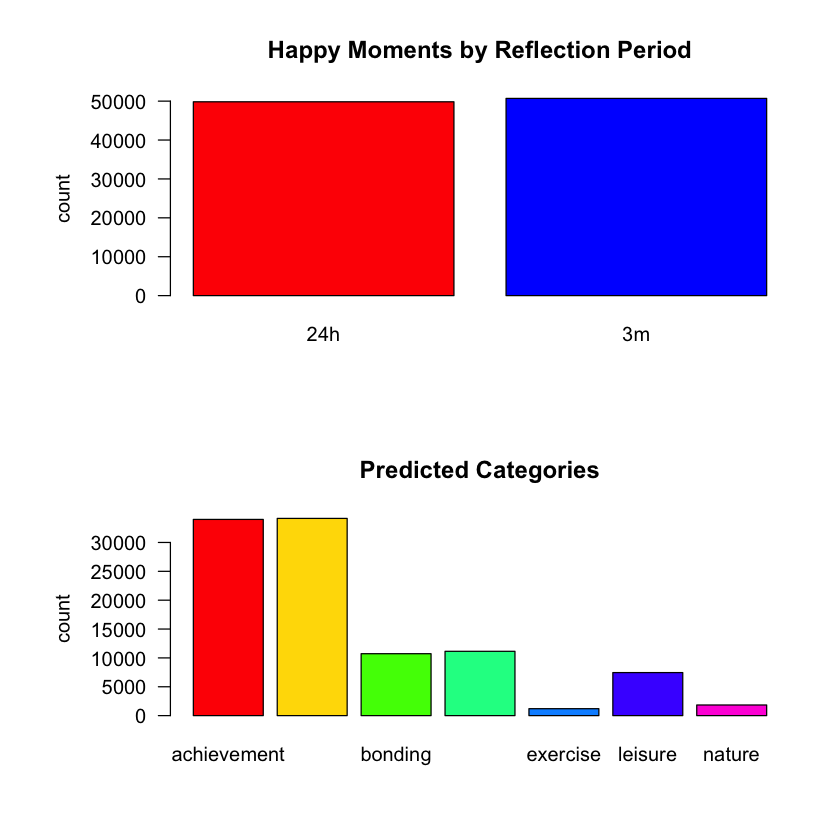

In [24]:
opt <- options("scipen" = 20)
op <- par(mar = c(5,7,4,2) + 0.1) #extra margin to accommodate tick labs
par(mfrow = c(2,1))

plot(data_HM$reflection_period, main="Happy Moments by Reflection Period", col =c('red', 'blue'), las = 1, ylab = "")
title(ylab = "count", line = 4)

plot(data_HM$predicted_category, main="Predicted Categories", col = rainbow(7), las = 1, ylab = "")
title(ylab = "count", line = 4)

par(op)
options(opt)

Summary Statistics of the Word Count

In [25]:
length(data_HM$cleaned_hm[])
wordcountcleaned = gsub(' {2,}',' ',data_HM$cleaned_hm)
summary(sapply(strsplit(wordcountcleaned[],' '), length))

[1] 100535

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    9.00   14.00   18.29   21.00 1155.00 

Examples of comments with 2 words

In [26]:
for(i in 1:length(data_HM$cleaned_hm[])){
if(sapply(strsplit(wordcountcleaned[i],' '), length)==2){print(toString(data_HM$cleaned_hm[i]))}}

[1] "Shooting guns."
[1] "My kids. "
[1] "dude, weed"
[1] "watching ncis."
[1] "Donated blood."
[1] "Doing laundry."
[1] "I relaxed."
[1] "It rained."
[1] "Playing minecraft."
[1] "I masturbated."
[1] "I pooed."
[1] "Waking up."
[1] "planning dinner."
[1] "Eating breakfast."
[1] "Won 50$"
[1] "Getting laid."
[1] "Going swimming!"
[1] "Drinking coffee."
[1] "Cousin's Marriage"
[1] "Eating fajitas!"
[1] "I graduated!"
[1] "Conductor drives."
[1] "sea food\nbeer"
[1] "Reading books."
[1] "It's Friday."
[1] "Stomouch swallon."
[1] "I cuddled."
[1] "Getting engaged."
[1] "Sleeping in."
[1] "I masturbated."
[1] "I walked."
[1] "I ran."
[1] "Getting hugged."
[1] "Worked out."


Distribution of the Word Count of the Happy Moments

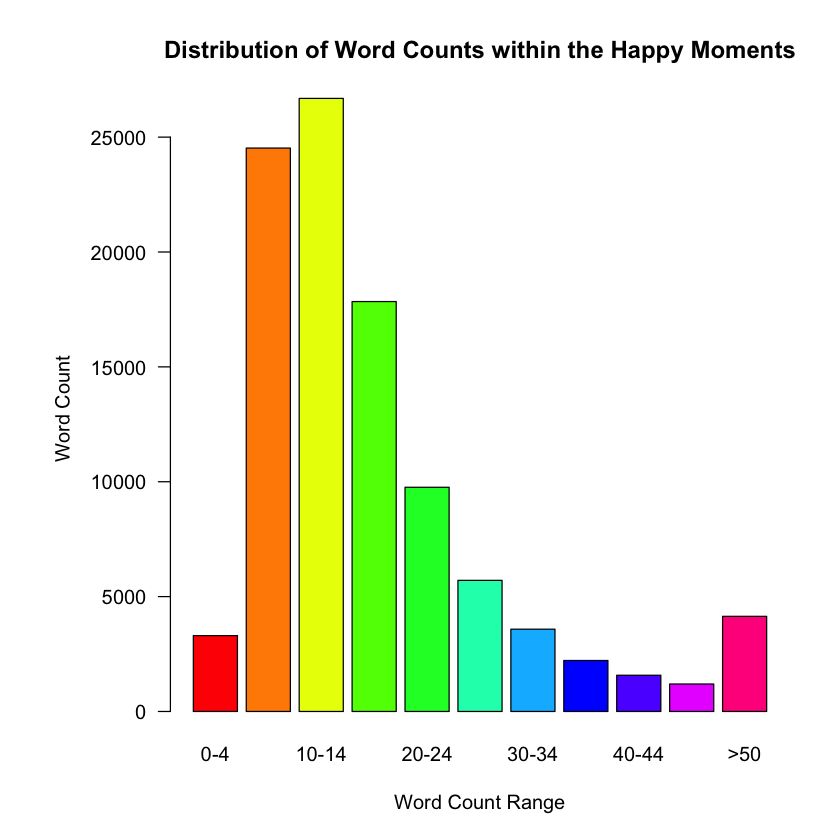

In [27]:
word_0_4= c()
word_05_09= c()
word_10_14= c()
word_15_19= c()
word_20_24= c()
word_25_29= c()
word_30_34= c()
word_35_39= c()
word_40_44= c()
word_45_49= c()
word_50= c()
for(i in 1:length(data_HM$cleaned_hm[])){
  if(sapply(strsplit(wordcountcleaned[i],' '), length) < 5){word_0_4 <<- c(word_0_4,i)}
  if(sapply(strsplit(wordcountcleaned[i],' '), length) < 10 && sapply(strsplit(wordcountcleaned[i],' '), length) > 4){word_05_09 <<- c(word_05_09,i)}
  if(sapply(strsplit(wordcountcleaned[i],' '), length) < 15 && sapply(strsplit(wordcountcleaned[i],' '), length) > 9){word_10_14 <<- c(word_10_14,i)}
  if(sapply(strsplit(wordcountcleaned[i],' '), length) < 20 && sapply(strsplit(wordcountcleaned[i],' '), length) > 14){word_15_19 <<- c(word_15_19,i)}
  if(sapply(strsplit(wordcountcleaned[i],' '), length) < 25 && sapply(strsplit(wordcountcleaned[i],' '), length) > 19){word_20_24 <<- c(word_20_24,i)}
  if(sapply(strsplit(wordcountcleaned[i],' '), length) < 30 && sapply(strsplit(wordcountcleaned[i],' '), length) > 24){word_25_29 <<- c(word_25_29,i)}
  if(sapply(strsplit(wordcountcleaned[i],' '), length) < 35 && sapply(strsplit(wordcountcleaned[i],' '), length) > 29){word_30_34 <<- c(word_30_34,i)}
  if(sapply(strsplit(wordcountcleaned[i],' '), length) < 40 && sapply(strsplit(wordcountcleaned[i],' '), length) > 34){word_35_39 <<- c(word_35_39,i)}
  if(sapply(strsplit(wordcountcleaned[i],' '), length) < 45 && sapply(strsplit(wordcountcleaned[i],' '), length) > 39){word_40_44 <<- c(word_40_44,i)}
  if(sapply(strsplit(wordcountcleaned[i],' '), length) < 50 && sapply(strsplit(wordcountcleaned[i],' '), length) > 44){word_45_49 <<- c(word_45_49,i)}
  if(sapply(strsplit(wordcountcleaned[i],' '), length) > 49){word_50 <<- c(word_50,i)}
}
distribution <- c(rep("0-4", length(word_0_4)),
                  rep("05-09", length(word_05_09)),
                  rep("10-14", length(word_10_14)),
                  rep("15-19", length(word_15_19)),
                  rep("20-24", length(word_20_24)),
                  rep("25-29", length(word_25_29)),
                  rep("30-34", length(word_30_34)),
                  rep("35-39", length(word_35_39)),
                  rep("40-44", length(word_40_44)),
                  rep("45-49", length(word_45_49)),
                  rep(">50", length(word_50)))
#plot the results
opt <- options("scipen" = 20)
op <- par(mar = c(5,7,4,2) + 0.1) #extra margin to accommodate tick labs
barplot(table(distribution), main="Distribution of Word Counts within the Happy Moments",
        xlab="Word Count Range",las = 1, ylab="", col = rainbow(11))
title(ylab = "Word Count", line = 4)
par(op)
options(opt)

Analysis of word occurences within the happy moments

In [12]:
First_range <- c(word_0_4, word_05_09)
Second_range <- c(word_10_14)
Third_range <- c(word_15_19, word_20_24, word_25_29, word_30_34, word_35_39, word_40_44, word_45_49, word_50)

In [15]:
data_occurency <- c()
for(i in 1:length(First_range)){data_occurency <- c(toString(data_occurency), toString(data_HM$cleaned_hm[i]))}
myCorpus <- Corpus(VectorSource(data_occurency))
tdm <- TermDocumentMatrix( myCorpus,
                          control = list(removePunctuation = TRUE ,
                          stopwords = c(stopwords("english")),
                          removeNumbers = TRUE ,
                          tolower = TRUE )
                                           )
m <- as.matrix(tdm)
word_freqs <- sort(rowSums(m), decreasing =TRUE )
dm_First_range <- data.frame(word= names( word_freqs), freq = word_freqs)

In [16]:
data_occurency <- c()
for(i in 1:length(Second_range)){data_occurency <- c(toString(data_occurency), toString(data_HM$cleaned_hm[i]))}
myCorpus <- Corpus(VectorSource(data_occurency))
tdm <- TermDocumentMatrix( myCorpus,
                            control = list(removePunctuation = TRUE ,
                            stopwords = c(stopwords("english")),
                            removeNumbers = TRUE ,
                            tolower = TRUE )
 )
 m <- as.matrix(tdm)
 word_freqs <- sort(rowSums(m), decreasing =TRUE )
 dm_Second_range <- data.frame(word= names( word_freqs), freq = word_freqs)

In [17]:
data_occurency <- c()
for(i in 1:length(Third_range)){data_occurency <- c(toString(data_occurency), toString(data_HM$cleaned_hm[i]))}
myCorpus <- Corpus(VectorSource(data_occurency))
tdm <- TermDocumentMatrix( myCorpus,
                            control = list(removePunctuation = TRUE ,
                            stopwords = c(stopwords("english")),
                            removeNumbers = TRUE ,
                            tolower = TRUE )
 )
 m <- as.matrix(tdm)
 word_freqs <- sort(rowSums(m), decreasing =TRUE )
 dm_Third_range <- data.frame(word= names( word_freqs), freq = word_freqs)

In [18]:
Top_word <- merge(dm_First_range, dm_Second_range, by="word", all = TRUE)
Top_word[is.na(Top_word)] <- 0
Top_word <- transform(Top_word, summation.col = freq.x + freq.y)
Top_word$freq.x <- NULL
Top_word$freq.y <- NULL
Top_word <- merge(Top_word, dm_Third_range, by="word", all = TRUE)
Top_word[is.na(Top_word)] <- 0
Top_word <- transform(Top_word, summation = summation.col + freq)
Top_word <- arrange(Top_word,desc(summation))
head(Top_word)

word  summation.col freq summation
1 happy 10568         9303 19871    
2 got    6945         6064 13009    
3 made   6666         5649 12315    
4 went   5401         4617 10018    
5 time   4621         4312  8933    
6 work   4502         3669  8171

Word Cloud of the most frequently used words

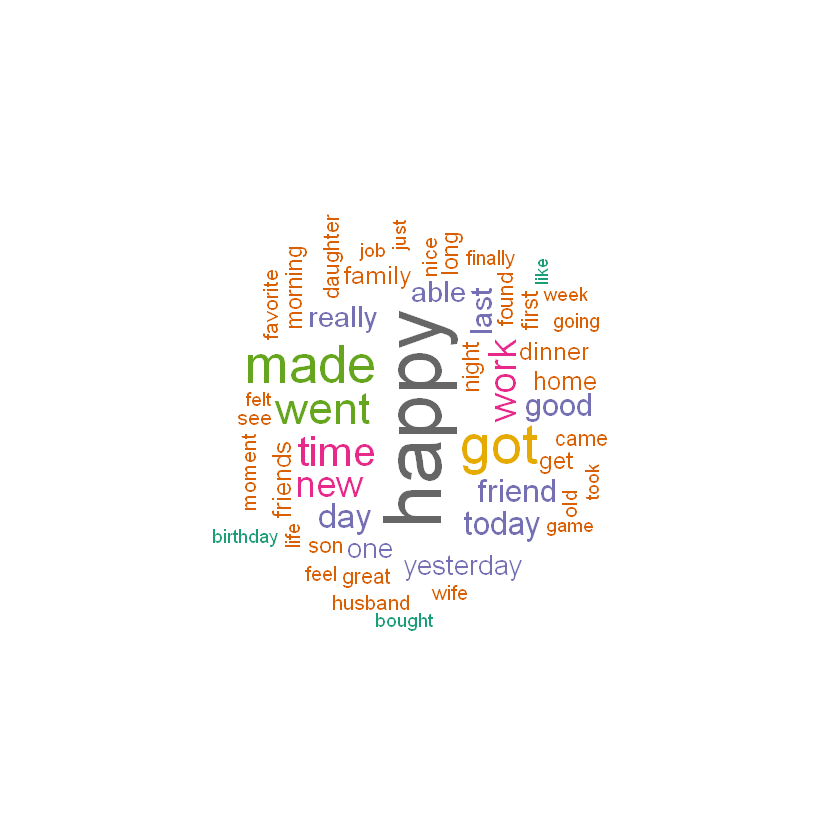

In [15]:
wordcloud(words = Top_word$word, freq = Top_word$summation, min.freq = 1,
          max.words=50, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2")) 

Word Cloud of the most frequently used words - without non-informative words

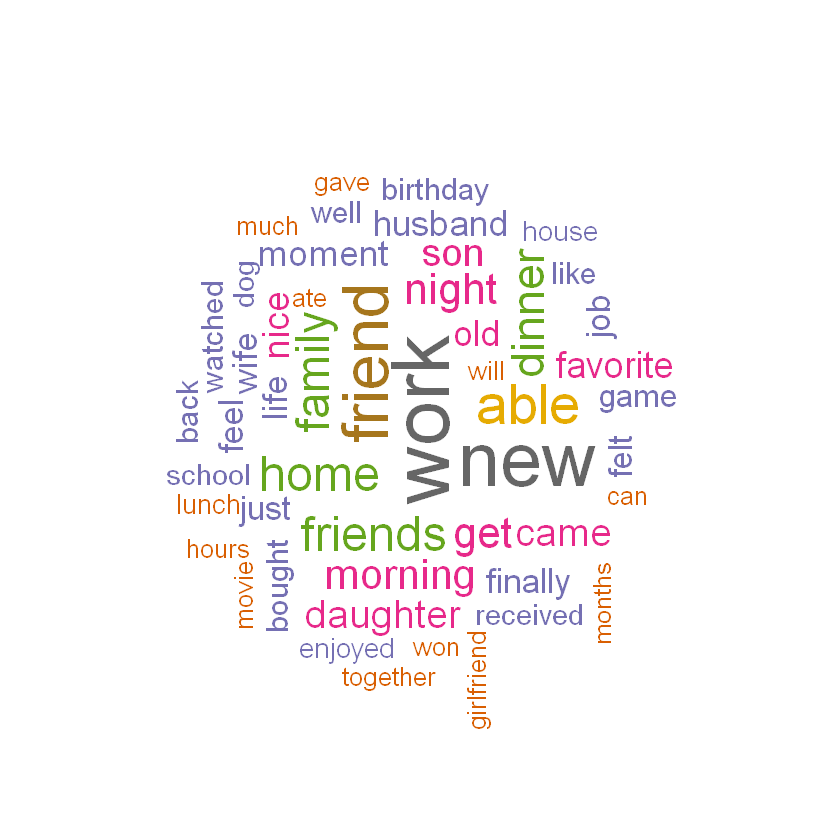

In [17]:
occurence <- c()
word_to_remove = c('happy', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going', 'getting', 'took', 'found', 'lot', 'really', 'saw', 'see', 'month', 'week', 'day', 'yesterday', 'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing','without')
for(i in 1:nrow(Top_word)){
  for(j in 1:length(word_to_remove)){
    if(word_to_remove[j] == Top_word[i,1]){
      occurence <- c(occurence, i)
    }
  }
}
Top_cleanword <- Top_word[-c(occurence), ]
wordcloud(words = Top_cleanword$word, freq = Top_cleanword$summation, min.freq = 1,
          max.words=50, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2")) 

Word Count of comments that mention a season

In [20]:
seasons <- c('spring', 'summer', 'fall', 'winter')
occurence <- c()
for(i in 1:nrow(Top_cleanword)){
  for(j in 1:length(seasons)){
    if(seasons[j] == Top_cleanword[i,1]){
      occurence <- c(occurence, i)
    }
  }
}

for(i in occurence){
  print(Top_cleanword[i,c(1,4)])
}


      word summation
238 summer       653
      word summation
274 spring       569
      word summation
896 winter       159
    word summation
990 fall       140


Word Count of comments that mention a technology company

In [21]:
brand <- c('facebook', 'amazon', 'apple', 'google', 'samsung')
occurence <- c()
for(i in 1:nrow(Top_cleanword)){
  for(j in 1:length(brand)){
    if(brand[j] == Top_cleanword[i,1]){
      occurence <- c(occurence, i)
    }
  }
}

for(i in occurence){
  print(Top_cleanword[i,c(1,4)])
}

      word summation
462 amazon       329
        word summation
693 facebook       214
      word summation
1358 apple        92
        word summation
3511 samsung        23
       word summation
4192 google        17


Word Count of comments that mention buying or purchasing

In [22]:
sentences <- strsplit(wordcountcleaned,' ')
get <- c('purchase', 'buy', 'purchasing', 'buying', 'purchases', 'purchased', 'sell', 'discount', 'discounted', 'order')
occurence <- c()
for(i in 1:length(sentences)){
  for (v in 1:length(sentences[[i]])) {
    for(j in 1:length(get)){
      if(get[j] == sentences[[i]][v]){
        occurence <- c(occurence, i)
      }
      
    }
  }
}

get_sentences <- c()
for(i in occurence){
  get_sentences <- c(get_sentences, toString(data_HM$cleaned_hm[[i]]))
}

myCorpus <- Corpus(VectorSource(get_sentences))
tdm <- TermDocumentMatrix( myCorpus,
                           control = list(removePunctuation = TRUE ,
                                          stopwords = c(stopwords("english")),
                                          removeNumbers = TRUE ,
                                          tolower = TRUE )
)
m <- as.matrix(tdm)
word_freqs <- sort(rowSums(m), decreasing =TRUE )
dm_get <- data.frame(word= names( word_freqs), freq = word_freqs)
head(dm_get)

word      freq
buy       buy       891 
happy     happy     765 
new       new       707 
purchased purchased 640 
purchase  purchase  431 
able      able      366

Word Cloud of comments that mention buying or purchasing

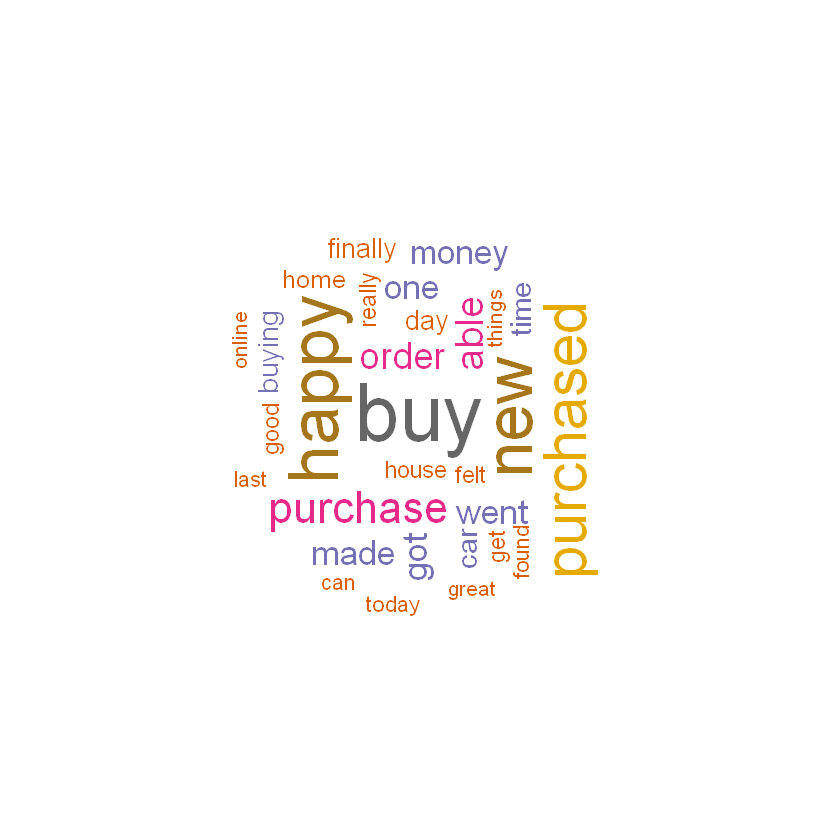

In [23]:
wordcloud(words = dm_get$word, freq = dm_get$freq, min.freq = 1,
          max.words=30, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2")) 

Word Cloud of comments that mention buying or purchasing - without non-informative words

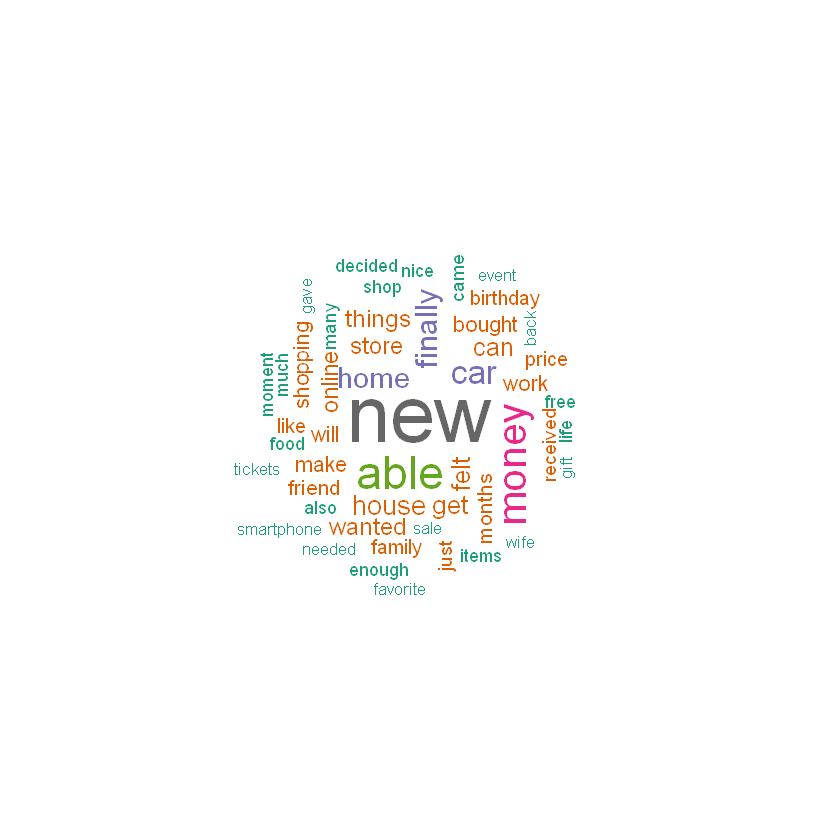

In [26]:
occurence <- c()
word_to_remove = c('purchase', 'buy', 'purchasing', 'buying', 'purchases', 'purchased', 'sell', 'discount', 'discounted', 'order', 'happy', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going', 'getting', 'took', 'found', 'lot', 'really', 'saw', 'see', 'month', 'week', 'day', 'yesterday', 'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing','without')
for(i in 1:nrow(dm_get)){
  for(j in 1:length(word_to_remove)){
    if(word_to_remove[j] == dm_get[i,1]){
      occurence <- c(occurence, i)
    }
  }
}
dm_cleanget <- dm_get[-c(occurence), ]
wordcloud(words = dm_cleanget$word, freq = dm_cleanget$freq, min.freq = 1,
          max.words=50, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2")) 

Overview of the Predicted Categories that describe the Happy Moments

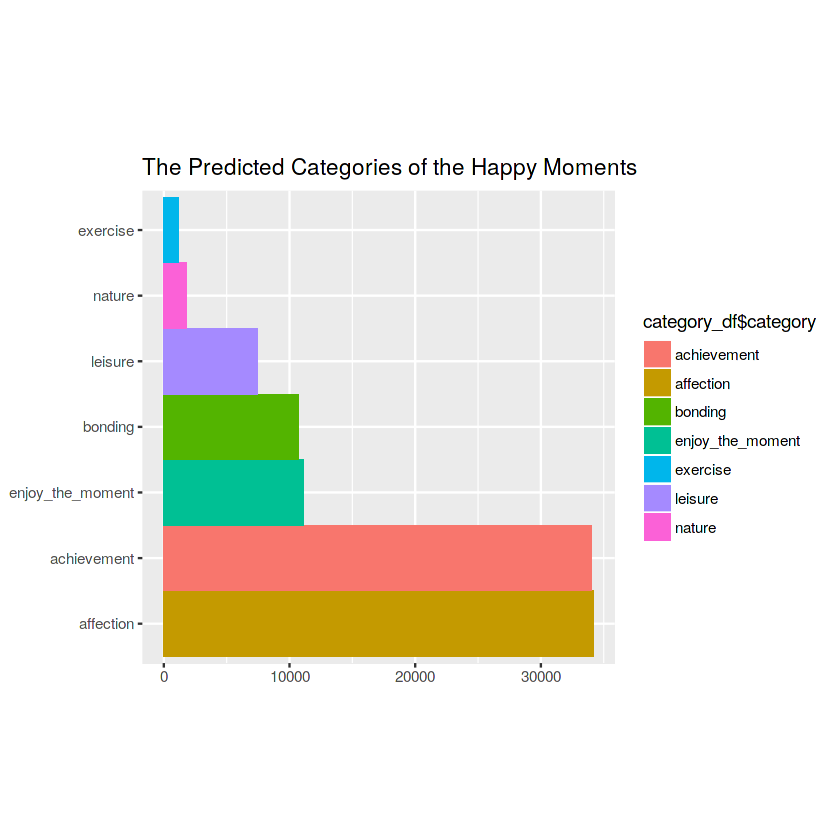

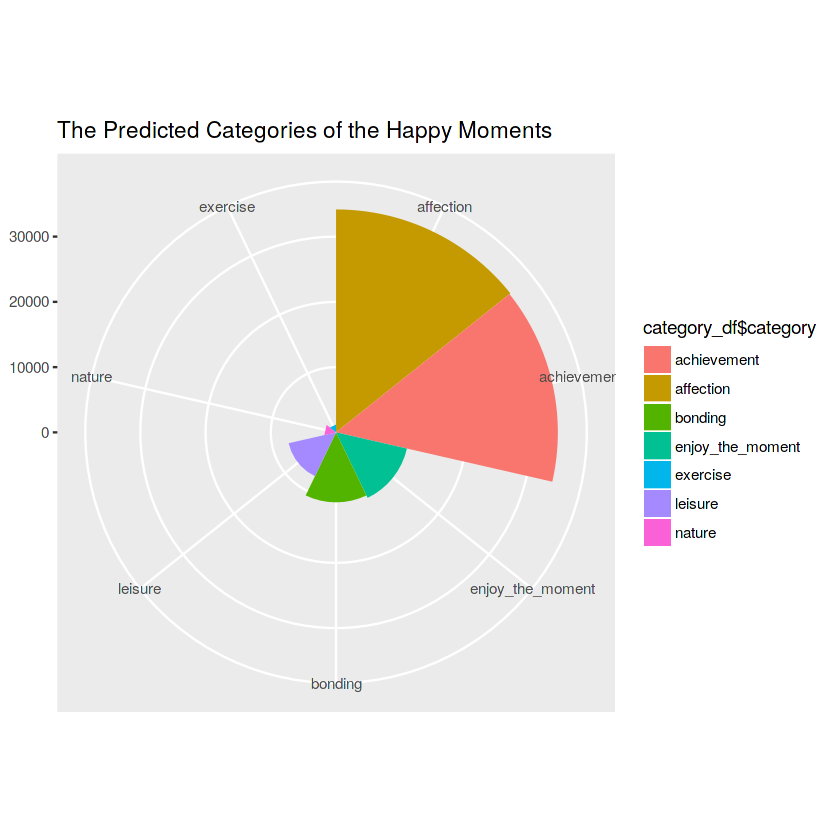

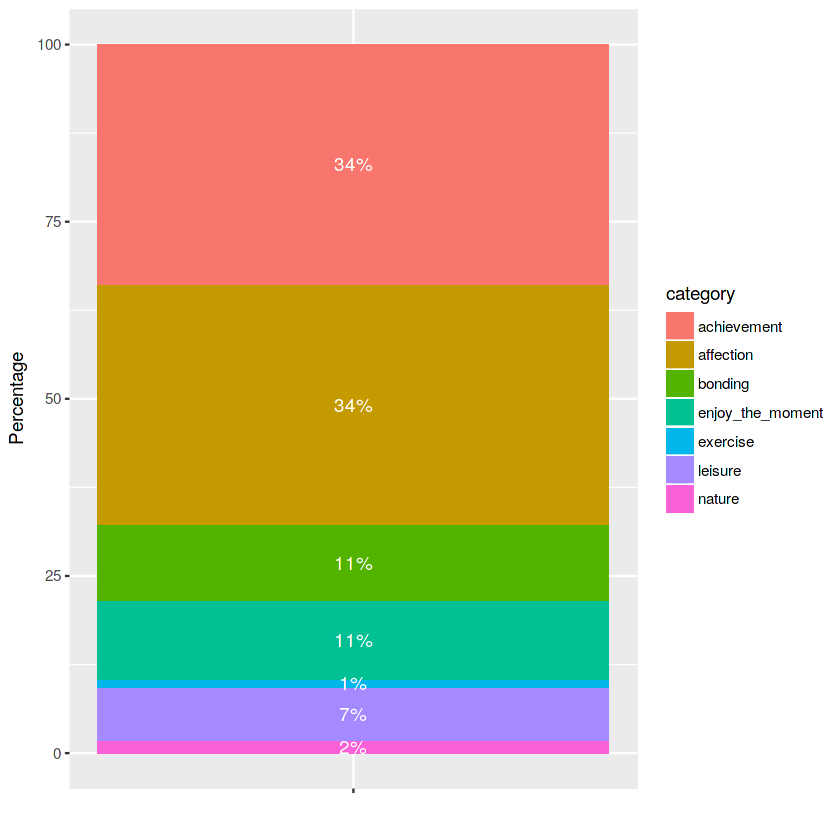

In [60]:
category <- table(data_HM$predicted_category)
category_df<-as.data.frame(category)
colnames(category_df) <- c("category", "count")
category_df<-category_df %>% ungroup() %>% mutate(percent = count/sum(count) * 100) %>% arrange(desc(count))
colnames(category_df) <- c("category", "count", "percent")

bar <- ggplot(data = category_df) +
    geom_bar(mapping = aes(x = reorder(category_df$category, -count), y=category_df$count, fill = category_df$category), stat="identity", width = 1) +
    theme(aspect.ratio = 1) +
    labs(x = "count", y = NULL, fill = "Predicted Category") +
    ggtitle("The Predicted Categories of the Happy Moments ")

bar + coord_flip()
bar + coord_polar()


barplot_predicted <- ggplot(category_df, aes(x = "", y = percent, fill = category))+
                        geom_bar(stat = "identity")+labs( x = "", y = "Percentage", fill = "Category")+
                        geom_text(aes(label = paste0(round(category_df$percent),"%")),
                                  color = "white", family = "Georgia", position = position_stack(vjust = 0.5))+
                    ggtitle("The Predicted Categories of the Happy Moments ")
barplot_predicted

Distribution of Word Count of the Happy Moments

In [21]:
wordcount <- sapply(strsplit(wordcountcleaned[],' '), length)
data_HM <- data.frame(data_HM, wordcount)
summary(data_HM$wordcount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    9.00   14.00   18.29   21.00 1155.00 

Binning of the Word Count into 4 Categories

In [22]:
data_HM$wordcount <- cut(data_HM$wordcount, breaks=c(quantile(data_HM$wordcount, probs = seq(0, 1, by = 0.25))), 
      labels=c("0-9","10-14","15-21","22-1155"), include.lowest=TRUE)

In [23]:
summary(data_HM$wordcount)

0-9   10-14   15-21 22-1155 
  27826   26686   22544   23479

Comparison of the Word Count in the Happy Moment and the Predicted Category - Can we predict the category based on how many words the comment has?

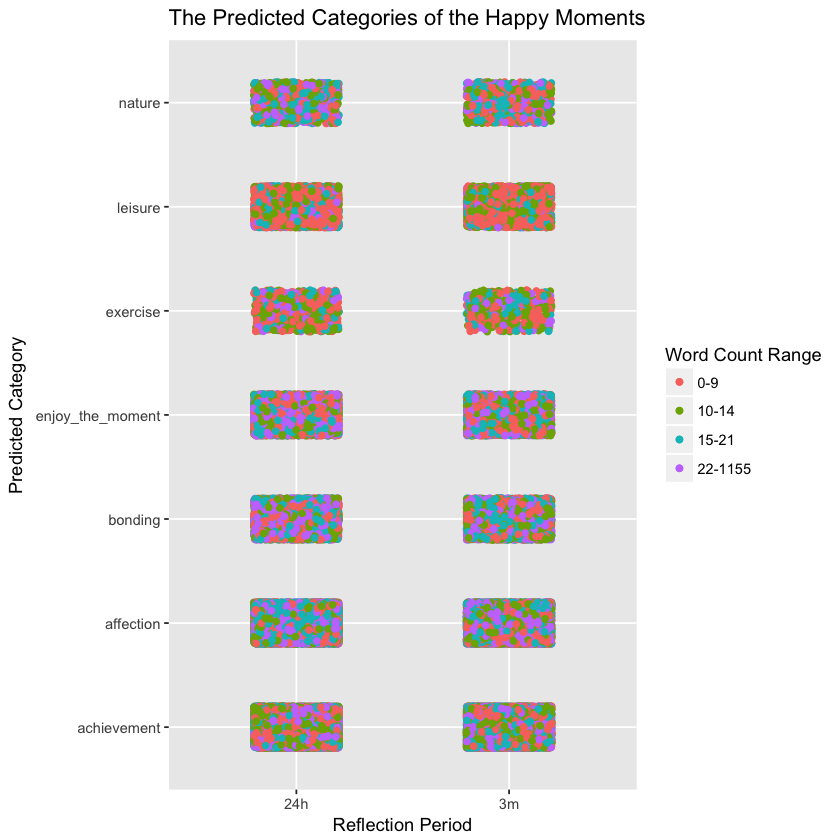

In [43]:
qplot(data_HM$reflection_period, data_HM$predicted_category, data=data_HM,
      color=data_HM$wordcount)+ geom_jitter(width = 0.2, height = 0.2)+
    labs(x = "Reflection Period", y = "Predicted Category", colour = "Word Count Range")+
ggtitle("The Predicted Categories of the Happy Moments")

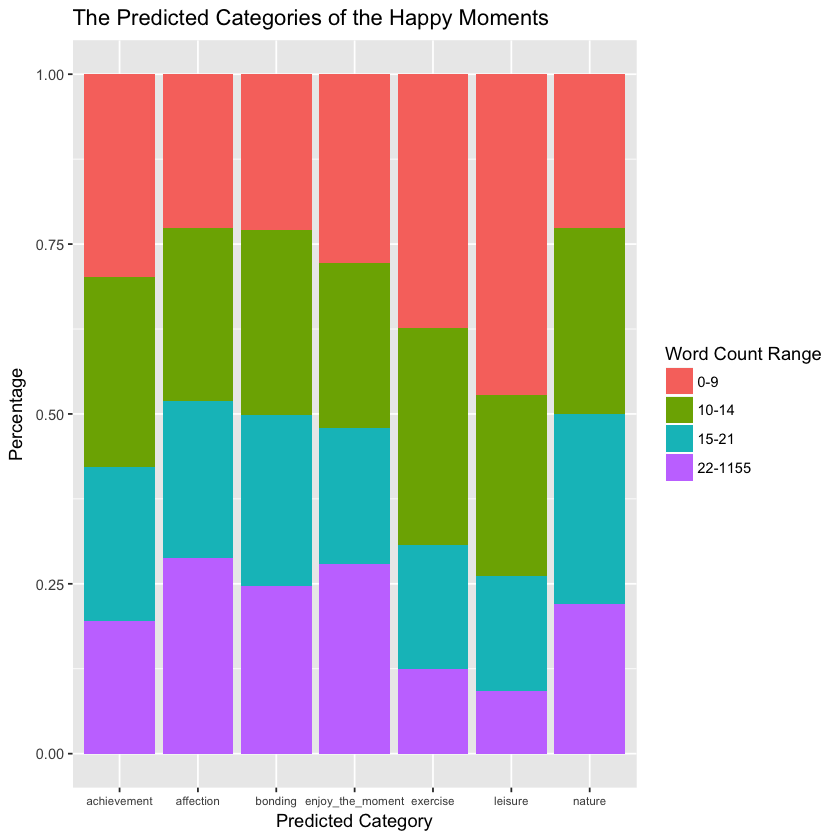

In [44]:
ggplot( data = data_HM ) + 
    geom_bar(mapping = aes( x = data_HM$predicted_category, fill = data_HM$wordcount),position = "fill")+ 
    labs(x = "Predicted Category",y = "Percentage",fill = "Word Count Range") + 
    theme(axis.text.x=element_text(size=7))+
    ggtitle("The Predicted Categories of the Happy Moments ")

As can be clearly see above, we cannot distinguish the category of the happy moment comment just by means of analyzing the word count of the comment. We need to take more data into account in order to find out what makes people happy.
In the following, we will explore the demographic data of the workers.

### 2. Demographic Data: Data Exploration and Clustering

Data Import

In [2]:
#data_Demographic <- read.csv("C:/Users/Antoine Lain/Desktop/demographic.csv")
data_demographic <- read.csv("/Users/jacquelineneef/Desktop/Kaggle/demographic.csv")

Data Understanding

In [3]:
head(data_demographic)

wid age  country gender marital parenthood
1 1   37.0 USA     m      married y         
2 2   29.0 IND     m      married y         
3 3   25   IND     m      single  n         
4 4   32   USA     m      married y         
5 5   29   USA     m      married y         
6 6   35   IND     m      married y

In [55]:
summary(data_demographic)

      wid             age          country     gender        marital    
 Min.   :    1   26     : 355   USA    :9274    :  32            :  57  
 1st Qu.: 2748   25     : 353   IND    : 964   f:5445   divorced : 565  
 Median : 6108   27     : 335          :  73   m:5311   married  :4371  
 Mean   : 6411   30     : 318   CAN    :  66   o:  56   separated: 102  
 3rd Qu.: 9982   29     : 317   VEN    :  54            single   :5678  
 Max.   :13839   24     : 302   GBR    :  48            widowed  :  71  
                 (Other):8864   (Other): 365                            
 parenthood
  :  31    
 n:6448    
 y:4365    
           
           
           
           

In [56]:
rapply(data_demographic,function(x)length(unique(x)))

wid        age    country     gender    marital parenthood 
     10844        140        101          4          6          3

In [57]:
sapply(data_demographic, class)

wid        age    country     gender    marital parenthood 
 "integer"   "factor"   "factor"   "factor"   "factor"   "factor"

Data Preparation of the categorical variables 'country', 'gender', 'marital', 'parenthood' - remove empty or non-informative rows

In [4]:
'%!in%' <- function(x,y)!('%in%'(x,y))
# data prep countries
data_demographic <- data_demographic[data_demographic$country %!in% c(""), ]
data_demographic$country <- droplevels.data.frame(data_demographic)$country
# data prep gender
data_demographic <- data_demographic[data_demographic$gender %!in% c("", "o"), ]
data_demographic$gender <- droplevels.data.frame(data_demographic)$gender
#data prep martial status
data_demographic <- data_demographic[data_demographic$marital %!in% c(""), ]
data_demographic$marital <- droplevels.data.frame(data_demographic)$marital
#data prep parenthood
data_demographic <- data_demographic[data_demographic$parenthood %!in% c(""), ]
data_demographic$parenthood <- droplevels.data.frame(data_demographic)$parenthood

Analyze the frequency (in %) of each category within 'country', 'gender', 'marital', 'parenthood'

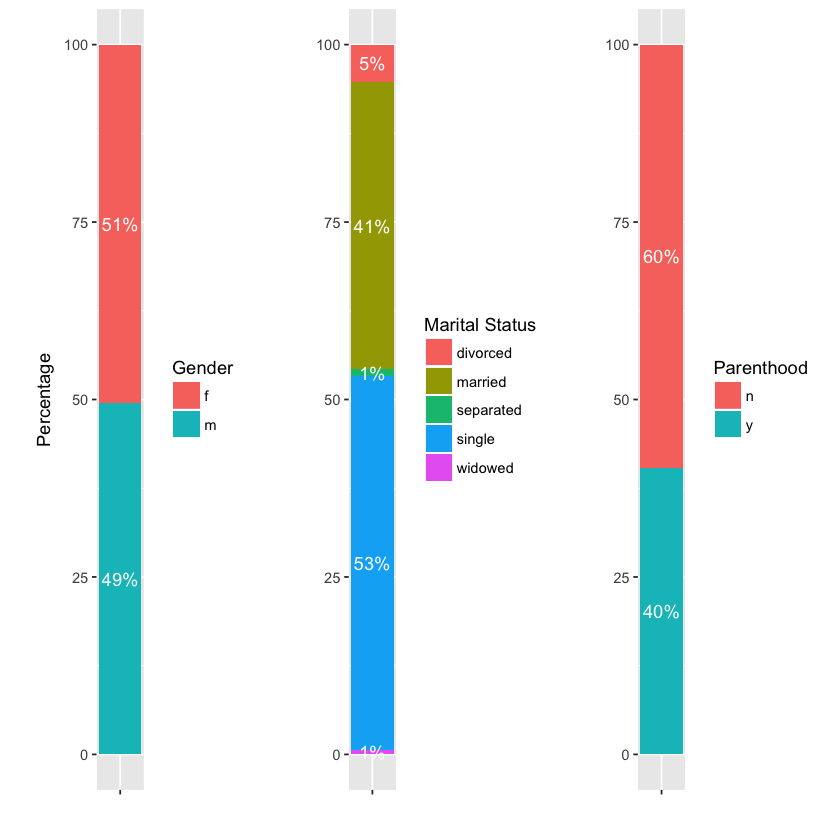

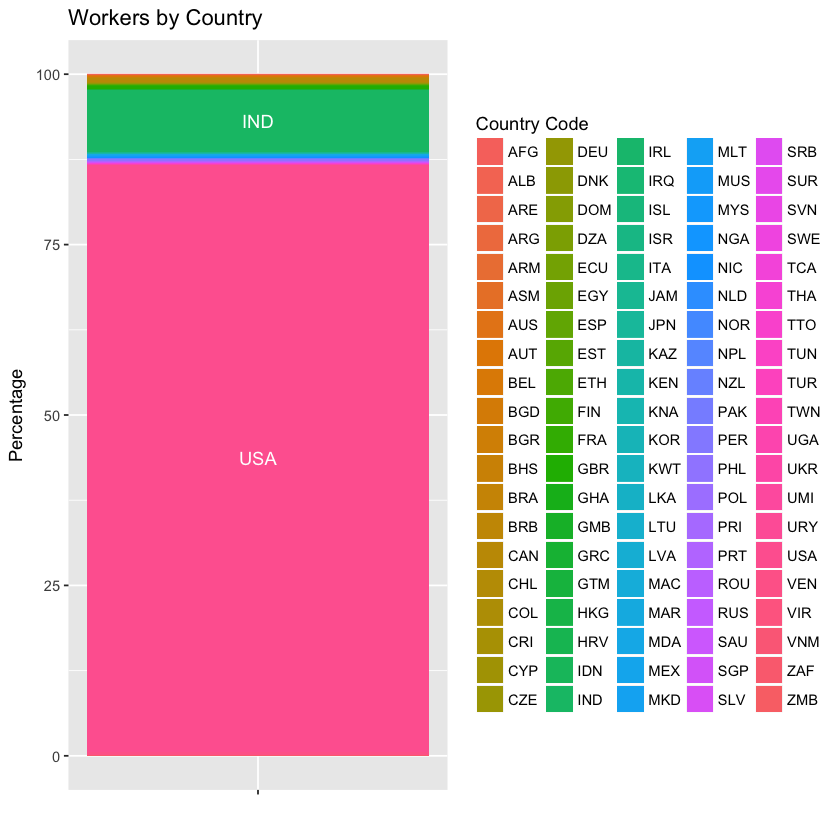

In [7]:
#get the percentages of the countries
counts_country <- table(data_demographic$country)
country_df<-as.data.frame(counts_country)
colnames(country_df) <- c("country", "count")
country_df<-country_df %>% ungroup() %>% mutate(percent = count/sum(count) * 100) %>% arrange(desc(count))
colnames(country_df) <- c("country", "count", "percent")

#get the percentages of the gender
gender <- table(data_demographic$gender)
gender_df<-as.data.frame(gender)
colnames(gender_df) <- c("gender", "count")
gender_df<-gender_df %>% ungroup() %>% mutate(percent = count/sum(count) * 100) %>% arrange(desc(count))
colnames(gender_df) <- c("gender", "count", "percent")

#get the percentages of marital status
marital <- table(data_demographic$marital)
marital_df<-as.data.frame(marital)
colnames(marital_df) <- c("marital", "count")
marital_df<-marital_df %>% ungroup() %>% mutate(percent = count/sum(count) * 100) %>% arrange(desc(count))
colnames(marital_df) <- c("marital", "count", "percent")

#get the percentages of parenthood
parenthood <- table(data_demographic$parenthood)
parenthood_df<-as.data.frame(parenthood)
colnames(parenthood_df) <- c("parenthood", "count")
parenthood_df<-parenthood_df %>% ungroup() %>% mutate(percent = count/sum(count) * 100) %>% arrange(desc(count))
colnames(parenthood_df) <- c("parenthood", "count", "percent")


# Barplots
barplot_gender <- ggplot(gender_df, aes(x = "", y = percent, fill = gender))+
                        geom_bar(stat = "identity")+labs( x = "", y = "Percentage", fill = "Gender")+
                        geom_text(aes(label = paste0(round(gender_df$percent),"%")), color = "white", position = position_stack(vjust = 0.5))+
                        coord_fixed(0.15)
barplot_marital <- ggplot(marital_df, aes(x = "", y = percent, fill = marital))+
                        geom_bar(stat = "identity")+labs( x = "", y="", fill = "Marital Status")+
                        geom_text(aes(label = paste0(round(marital_df$percent),"%")), color = "white", position = position_stack(vjust = 0.5))+
                        coord_fixed(0.15)
barplot_parenthood <- ggplot(parenthood_df, aes(x = "", y = percent, fill = parenthood))+
                        geom_bar(stat = "identity")+labs( x = "", y = "", fill = "Parenthood")+
                        geom_text(aes(label = paste0(round(parenthood_df$percent),"%")), color = "white", position = position_stack(vjust = 0.5))+
                        coord_fixed(0.15)

grid.arrange(barplot_gender, barplot_marital,barplot_parenthood, ncol=3, nrow = 1)

barplot_country <- ggplot(country_df, aes(x = "", y = percent, fill = country))+
                    geom_bar(stat = "identity")+
                    geom_text(aes(label =ifelse(country_df$percent >= 0.9, paste0(country_df$country),"")), color = "white", position = position_stack(vjust = 0.5))+
                    labs(title = "Workers by Country",
                         x = "", y = "Percentage", fill = "Country Code")
barplot_country

In the exploration above, we can clearly see that most of the workers (~95%) come from the US and India. All other countries combined account for only 5% of the workers. In order to keep the amount of categories as low as possible for the future analysis, we combine all other countries into the category "Other".

In [5]:
#label all countries that are not US and India as "Other"
levels(data_demographic$country)[levels(data_demographic$country) %!in% c("USA", "IND")] <- "Other"
data_demographic$country <- droplevels.data.frame(data_demographic)$country

Data Summary after the preparation of the categorical variables:

In [6]:
summary(data_demographic)

      wid             age        country     gender        marital    
 Min.   :    1   25     : 352   Other: 527   f:5379   divorced : 554  
 1st Qu.: 2713   26     : 351   IND  : 958   m:5267   married  :4318  
 Median : 6028   27     : 334   USA  :9161            separated:  99  
 Mean   : 6375   29     : 317                         single   :5607  
 3rd Qu.: 9946   30     : 309                         widowed  :  68  
 Max.   :13839   24     : 297                                         
                 (Other):8686                                         
 parenthood
 n:6350    
 y:4296    
           
           
           
           
           

In [62]:
sapply(data_demographic, class)

wid        age    country     gender    marital parenthood 
 "integer"   "factor"   "factor"   "factor"   "factor"   "factor"

In [26]:
summary(data_demographic$age)

25      26      27      29      30      24      28      31      32      23 
    352     351     334     317     309     297     297     280     272     258 
   26.0    27.0    25.0    28.0    29.0      34      22    23.0    30.0      33 
    258     256     244     244     236     232     224     221     219     213 
     35    32.0      21    24.0      36    22.0    33.0    31.0    34.0    35.0 
    204     189     184     182     182     180     157     155     155     144 
     38    21.0      37    36.0      20      40      39      41    37.0    20.0 
    141     134     133     120     117     111     109     101     100      94 
     19    38.0    19.0      44    40.0      42      46    39.0    42.0      43 
     86      81      75      74      72      69      69      68      68      64 
     45    41.0    45.0    43.0      50      51      55      49      47      54 
     64      60      59      56      53      52      52      50      49      49 
   44.0      48      56      52      18    18.0    51.0      53    46.0    47.0 
     47      43      42      41      40      39      39      39      36      34 
   49.0    48.0    52.0    54.0      58    55.0      57    50.0    53.0      59 
     33      30      30      29      28      26      26      25      25      25 
     60      62    60.0      64      61    57.0      66    62.0    56.0    61.0 
     25      25      22      22      21      20      20      19      17      15 
   58.0    59.0      65              63    65.0      67    63.0    68.0 (Other) 
     14      14      14      12      12      12      10       9       7      83

Data Preparation - Age

As can be seen above, the age variable is considered as a factor/categorical variable, even though the values are numeric. In order to be able to correctly analyze the distribution of the age, we will transform the categorical age variable into numeric.
Further, we clean it by ensuring that the age has meaningful values - we decided to limit this to within 18 to 65 years. For any missing values, as well as values below or above, we decided to simply assign the mean age to that worker. Also, we round all values to integers.

In [7]:
data_demographic$age <- as.numeric(as.character(data_demographic$age))
data_demographic$age[data_demographic$age < 18 | data_demographic$age > 65 ] <- NA #only condsider ages from 18-65
data_demographic$age[is.na(data_demographic$age)] <- mean(data_demographic$age, na.rm = TRUE) #replace NA values by the mean
data_demographic$age <- round(data_demographic$age,digits=0)#round all values to integers
summary(data_demographic$age)

Warning message in eval(expr, envir, enclos):
“NAs durch Umwandlung erzeugt”

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.00   25.00   30.00   32.35   37.00   65.00 

In [6]:
sapply(data_demographic, class)

wid        age    country     gender    marital parenthood 
 "integer"  "numeric"   "factor"   "factor"   "factor"   "factor"

Analysis of the distribution of age of the workers

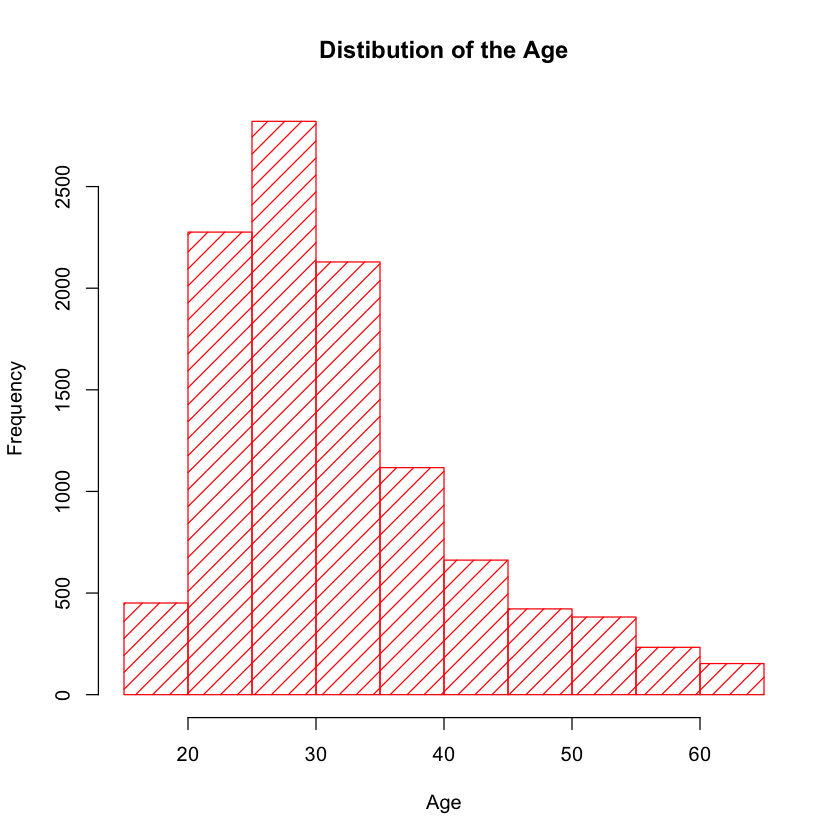

In [65]:
h <- hist(data_demographic$age, breaks = 10, density = 10,
          col = "red", xlab = "Age", main = "Distibution of the Age")

Since 85.5% of the people in the dataset are from the US - we compare the distribution given above to the age of the US population:

![Image of the US Population](https://www.census.gov/content/dam/Census/newsroom/blogs/2016/06/americas-age-profile-told-through-population-pyramids/Chart-1.png)

As can be seen in the graphic above, the distribution of age in the United States in the range 18-65 can be approximated by a uniform distribution $\mathcal{U(18,65)}$. Next, we compare our empirical distribution of age from the demographic data of the workers to the theoretical distribution of the U.S. population.

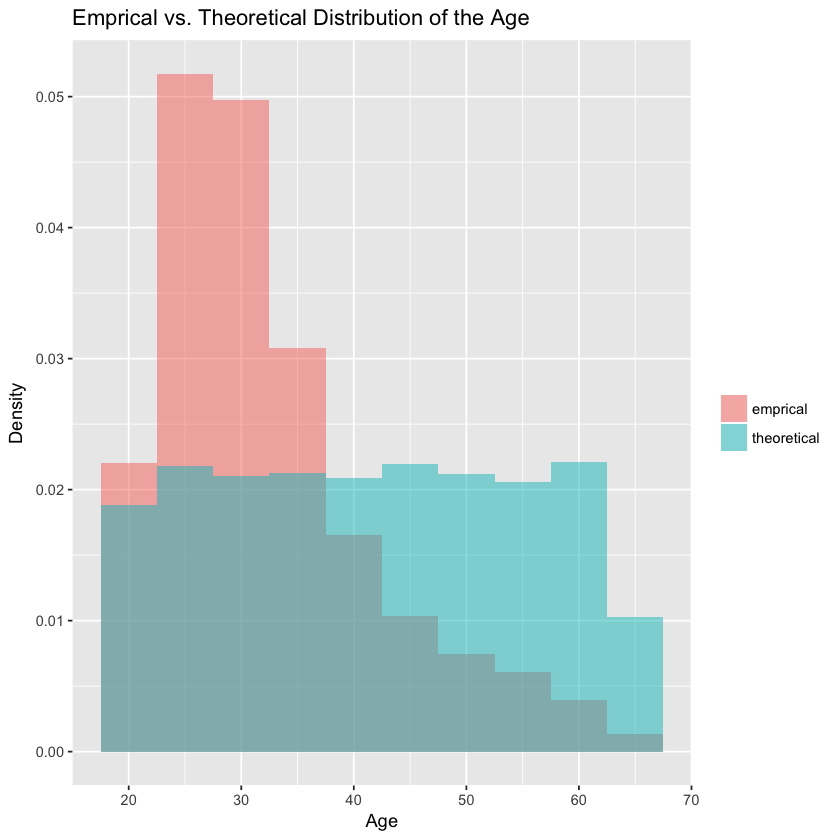

In [66]:
theoretical <- data.frame(age = runif(10000, min=18, max=65))
emprical <- data.frame(age = data_demographic$age)
theoretical$values <- 'theoretical'
emprical$values <- 'emprical'
comparison <- rbind(emprical, theoretical)

ggplot(comparison, aes(age, fill = values)) +
    geom_histogram(alpha = 0.5, aes(y = ..density..), binwidth=5, position = 'identity')+
    labs(title = "Emprical vs. Theoretical Distribution of the Age",x = "Age", y = "Density", fill = "")

Comparing the empirical and the theoretical distribution, we can clearly see that our empirical distribution has a positive skew (it is leaned to the left). Practically speaking, this means that the Amazon Mechanical Turk workers mainly represent the younger age group (<40 years old).

Using the knowledge of the distribution of the age, we decide the bins of the age in order to split our data into representative categories, where there is an approximately equal amount of workers in each category.
<br>(Remark: We used the handwritten - and less elegant - function below, because we faced issues loading the arules::discretize() function into our R Jupyter Notebook).

In [8]:
age <- c()
a <- "[18.00,25.00]"
b <- "[26.00,30.00]"
c <- "[31.00,37.00]"
d <- "[38.00,65.00]"
for(i in 1:length(data_demographic$age[])){
  if(data_demographic$age[i] < 26 ){ age <- c(age, as.character(a))}
  if(data_demographic$age[i] > 25 && data_demographic$age[i] < 31){age <- c(age, as.character(b))}
  if(data_demographic$age[i] > 30 && data_demographic$age[i] < 38){age <- c(age, as.character(c))}
  if(data_demographic$age[i] > 37 ){age <- c(age, as.character(d))}
}
data_demographic <- data_demographic[,-2]
data_demographic <- cbind(data_demographic, age)
summary(data_demographic)

      wid         country     gender        marital     parenthood
 Min.   :    1   Other: 527   f:5379   divorced : 554   n:6350    
 1st Qu.: 2713   IND  : 958   m:5267   married  :4318   y:4296    
 Median : 6028   USA  :9161            separated:  99             
 Mean   : 6375                         single   :5607             
 3rd Qu.: 9946                         widowed  :  68             
 Max.   :13839                                                    
            age      
 [18.00,25.00]:2727  
 [26.00,30.00]:2821  
 [31.00,37.00]:2664  
 [38.00,65.00]:2434  
                     
                     

## Clustering

For the clustering, we take the demographic data into account:

In [9]:
head(data_demographic)

wid country gender marital parenthood age          
1 1   USA     m      married y          [31.00,37.00]
2 2   IND     m      married y          [26.00,30.00]
3 3   IND     m      single  n          [18.00,25.00]
4 4   USA     m      married y          [31.00,37.00]
5 5   USA     m      married y          [26.00,30.00]
6 6   IND     m      married y          [31.00,37.00]

We used the Gower metric as the distance measure, because all of our data is categorical.
By using the Gower distance, the dissimilarity between two rows is the weighted mean of the contributions of each variable. Hereby, the distance measure is between 0 and 1 for each variable:

$$
\begin{equation}
d_{ij} = d(i,j) =\dfrac{\sum\limits_{c=1}^{n}w_c \delta_{(ij)}^{(c)} d_{(ij)}^{(c)}}{\sum\limits_{c=1}^{n}w_c \delta_{(ij)}^{(c)}}
\end{equation}$$

$$
\begin{equation}
d(i,j) = \text{dissimilarity between row $ i $ and row $ j $ }
\end{equation}
$$

$$
\text{$c$} = \text{the $cth$ column}
$$

$$
\text{$n$} = \text{number of columns in the dataset}
$$

$$
\begin{equation}
w_{c} = \text{weight of column} = \frac{1}{\text{nrows in dataset}}
\end{equation}
$$

$$
\delta_{(ij)}^{(c)} =
\begin{equation}
  \left\{
    \begin{array}{l}
      0 \text{ if column $c$ is missing in row $ i $ or $ j$}\\
      0 \text{ if column $c$ is asymmetric binary and both values in row $ i $ and $ j $ are 0}\\
      1 \text{ otherwise }
    \end{array}
  \right.
\end{equation}
$$

$$
d_{(ij)}^{(c)}(categorical) =
\begin{equation}
  \left\{
    \begin{array}{l}
      0 \text{ if  $i$ and $j$ are equal in column $c$ }\\
      1 \text{ otherwise }
    \end{array}
  \right.
\end{equation}
$$

$$
\begin{equation}
d_{(ij)}^{(c)}(continuous/ordinal) = \frac{\left|\text{row $i$ in column $c$ - row $j$ in colum $c$}\right|}{\text{$max$(column $c$) - $min$(column $c$)}}
\end{equation}
$$

source: https://healthcare.ai/clustering-non-continuous-variables

At first, in order to be able to do the clustering for our categorical data, we compute a distance matrix:

In [10]:
#we compute a dissimilarity matrix using the Gower distance on the data_demographic dataframe without the wid
dmatrix <- daisy(data_demographic[2:6], metric = "gower")

In the following, we will compute and compare three different clustering methods:
1. K-Means
2. Partitioning Aroung Mediods
3. Hierachical Clustering

### K-Means

At first, we would like to apply k-means clustering to our data. However, we need to set the number of clusters k a priori. In order to get the appropriate number of clusters k, we will use the Elbow Method:
<br> source https://datascienceplus.com/finding-optimal-number-of-clusters/

[1] 4464700.1 2269398.7 2038039.8 1631248.9 1378511.8 1199971.3 1187532.4
 [8] 1118564.9 1161011.4  883140.4 1097628.8  836849.5  884528.4  700103.1
[15]  774494.3

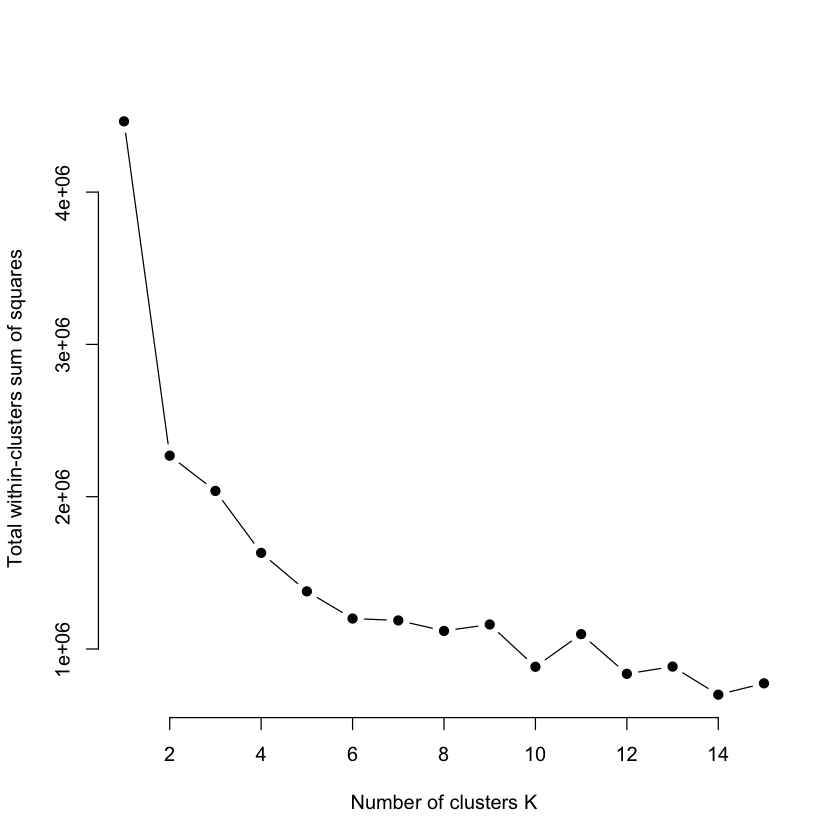

In [42]:
# Compute and plot wss for k = 2 to k = 15.
wss <- sapply(1:15, 
              function(k){kmeans(dmatrix, k)$tot.withinss})
wss
plot(1:15, wss,
     type="b", pch = 19, frame = FALSE, 
     xlab="Number of clusters K",
     ylab="Total within-clusters sum of squares")

We want a small SSE (sum of squared errors), but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster). *So our goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.*

We tried the Elbow Method, but it is difficult to interpret which is the best k given our data. However, we have gotten a hint that the optimal number of clusters should be around k=10. Following this, we calcluated the silhouette width for all k $\in$ [6;14] in order to determine the optimal k for our data:

In [13]:
pamk.best <- pamk(dmatrix)
cat("number of clusters estimated by optimum average silhouette width:", pamk.best$nc, "\n")

number of clusters estimated by optimum average silhouette width: 10 


Silhouette analysis measures how well an observation is clustered and it estimates the average distance between clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters.

For each observation $i$, the silhouette width $s_i$ is calculated as follows:


For each observation $i$, calculate the average dissimilarity $a_i$ between $i$ and all other points of the cluster to which $i$ belongs.
For all other clusters $C$, to which $i$ does not belong, calculate the average dissimilarity $d(i,C)$ of $i$ to all observations of $C$. The smallest of these $d(i,C)$ is defined as $b_i=\min_C d(i,C)$. The value of $b_i$ can be seen as the dissimilarity between $i$ and its “neighbor” cluster, i.e., the nearest one to which it does not belong.

Finally the silhouette width of the observation $i$ is defined by the formula: $S_i=\frac{(b_i−a_i)}{\max(a_i,b_i)}$.

As a result, a silhouette width around 0 indicates the data point is intermediate between two clusters, silhouette width close to 1 indicates that the point is well assigned and a silhouette width close to –1 indicates that the point is poorly assigned.

#### Perform K-Means clustering

In [ ]:
km.res6 <- kmeans(dmatrix, 6)
km.res7 <- kmeans(dmatrix, 7)
km.res8 <- kmeans(dmatrix, 8)
km.res9 <- kmeans(dmatrix, 9)
km.res10 <- kmeans(dmatrix, 10)
km.res11 <- kmeans(dmatrix, 11)
km.res12 <- kmeans(dmatrix, 12)
km.res13 <- kmeans(dmatrix, 13)
km.res14 <- kmeans(dmatrix, 14)
mkm.res6 <- mean(silhouette(km.res6$cluster, dmatrix)[, 3])
mkm.res7 <- mean(silhouette(km.res7$cluster, dmatrix)[, 3])
mkm.res8 <- mean(silhouette(km.res8$cluster, dmatrix)[, 3])
mkm.res9 <- mean(silhouette(km.res9$cluster, dmatrix)[, 3])
mkm.res10 <- mean(silhouette(km.res10$cluster, dmatrix)[, 3])
mkm.res11 <- mean(silhouette(km.res11$cluster, dmatrix)[, 3])
mkm.res12 <- mean(silhouette(km.res12$cluster, dmatrix)[, 3])
mkm.res13 <- mean(silhouette(km.res13$cluster, dmatrix)[, 3])
mkm.res14 <- mean(silhouette(km.res14$cluster, dmatrix)[, 3])
km_result <- c(mkm.res6,
mkm.res7,
mkm.res8,
mkm.res9,
mkm.res10,
mkm.res11,
mkm.res12,
mkm.res13,
mkm.res14)

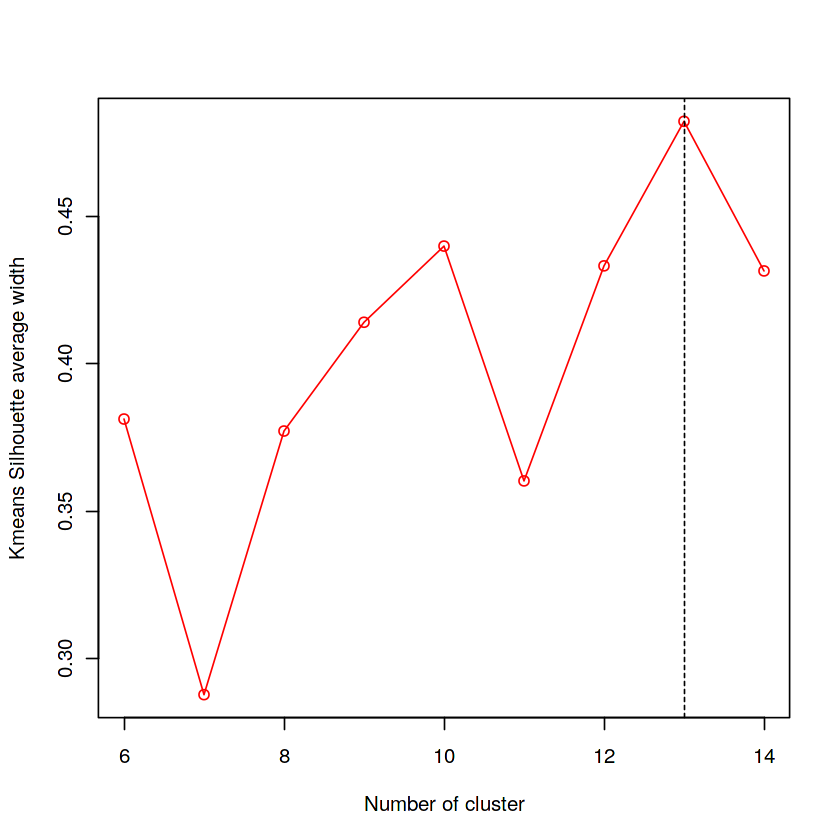

In [151]:
plot(6:14, km_result, type="o", col="red", xlab = "Number of cluster", ylab = "Kmeans Silhouette average width")
abline(v = 13, lty =2)

This graph shows the values of the average Silhouette for the different number of clusters. We highlight that with K=13 there is the highest value followed by a non-increased value. 
This means that for our dataset K=13 is the optimal number of cluters regarding how close each point in one cluster is to points in the neighboring clusters.

In [153]:
silhouette(km.res13$cluster, dmatrix)

         cluster neighbor    sil_width
    [1,]       3        9  0.570570213
    [2,]      12        3  0.448423860
    [3,]       4       13  0.437085701
    [4,]       3        9  0.570570213
    [5,]       3        9  0.432552311
    [6,]      12        3  0.462711453
    [7,]       3        9  0.570570213
    [8,]       4       13  0.247913318
    [9,]       7        3  0.580818028
   [10,]      13        6  0.592460836
   [11,]       6       13  0.126047408
   [12,]       5        8  0.622900157
   [13,]      12        3  0.428802054
   [14,]      12        3  0.389918155
   [15,]       3        9  0.432552311
   [16,]      13        6  0.501822386
   [17,]      13        6  0.592460836
   [18,]      13        6  0.592460836
   [19,]       6       13  0.532400365
   [20,]       3       12  0.596390230
   [21,]       1        9 -0.331603877
   [22,]      13        6  0.501822386
   [23,]       4       13  0.344398122
   [24,]       8        5  0.183510962
   [25,]      12        3

   cluster size ave.sil.width
1        1  156         -0.01
2        2  417          0.43
3        3 1058          0.51
4        4  484          0.34
5        5 1793          0.58
6        6  520          0.44
7        7 2025          0.45
8        8  221          0.26
9        9  184          0.51
10      10  668          0.35
11      11  255          0.40
12      12  321          0.37
13      13 2544          0.58


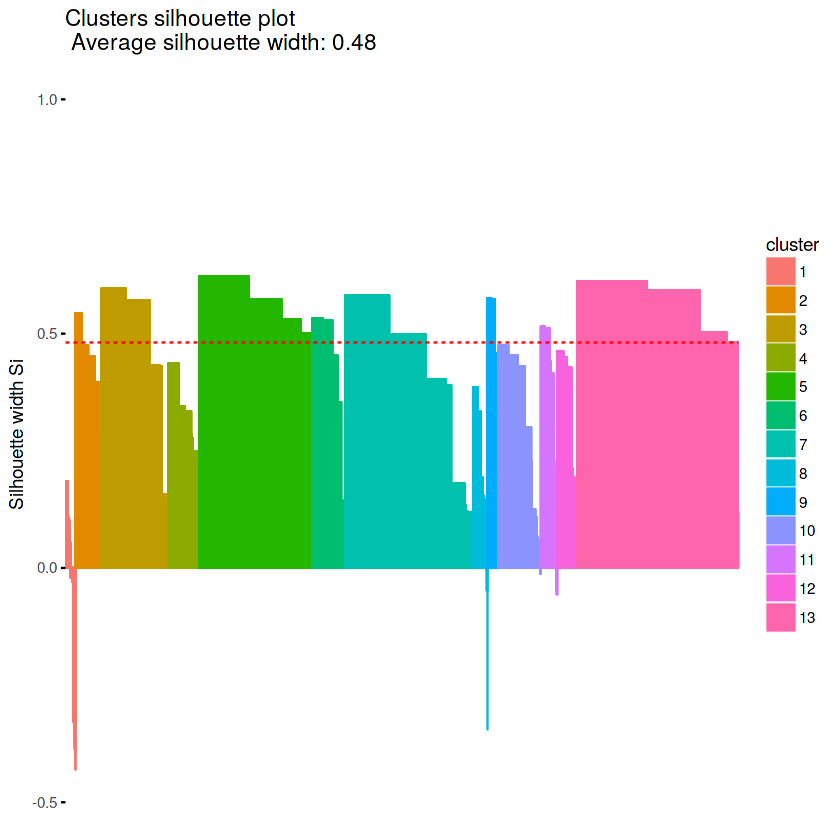

In [152]:
fviz_silhouette(silhouette(km.res13$cluster, dmatrix)) 

With K-means algorithm set at K=13 we can appreciate some poorly assigned datapoints (in clusters 1, 9, 10 and 12) and a general average silhouette value of 0.48 which represents that the overall quality of the clustering is not bad. 

In [11]:
km13 <- kmeans(dmatrix, 13)

### Partitioning Around Medoids

PAM is a clustering algorithm related to the k-means that uses datapoints as centers (medoids or exemplars) instead of theorical points. Since this method minimizes the absolute distance between the points and the selected centroid, rather than minimizing the square distance, it's more robust to noise and outliers than k-means.

#### Perform PAM clustering

In [116]:
pam.res6 <- pam(dmatrix, 6)
pam.res7 <- pam(dmatrix, 7)
pam.res8 <- pam(dmatrix, 8)
pam.res9 <- pam(dmatrix, 9)
pam.res <- pam(dmatrix, 10)
pam.res11 <- pam(dmatrix, 11)
pam.res12 <- pam(dmatrix, 12)
pam.res13 <- pam(dmatrix, 13)
pam.res14 <- pam(dmatrix, 14)
pam_result <- c(pam.res6$silinfo$avg.width,
pam.res7$silinfo$avg.width,
pam.res8$silinfo$avg.width,
pam.res9$silinfo$avg.width,
pam.res$silinfo$avg.width,
pam.res11$silinfo$avg.width,
pam.res12$silinfo$avg.width,
pam.res13$silinfo$avg.width,
pam.res14$silinfo$avg.width)

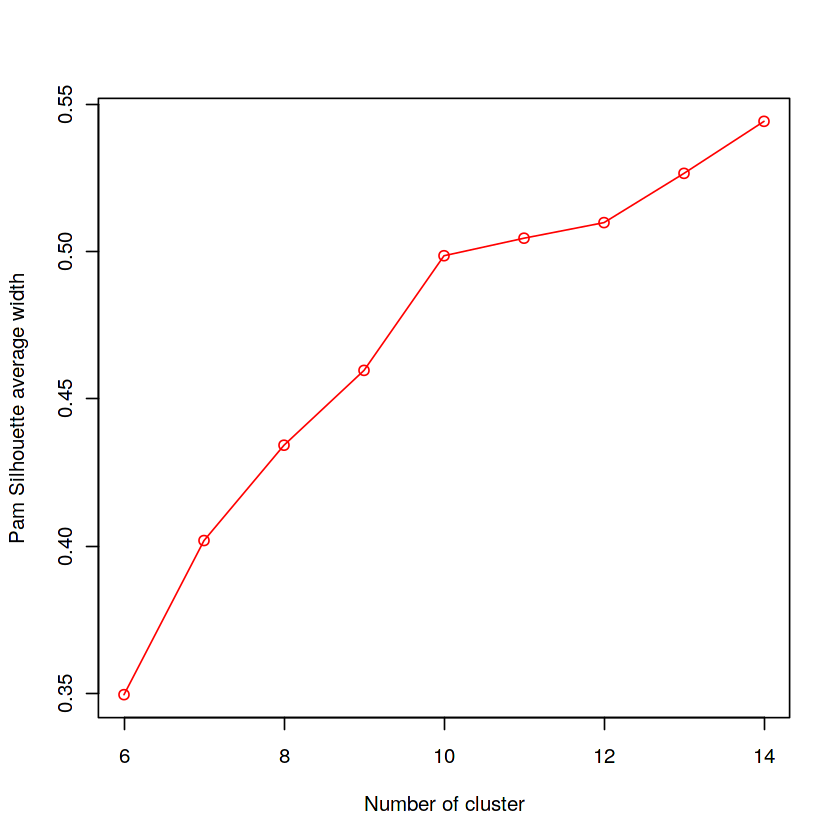

In [122]:
plot(6:14, pam_result, type="o", col="red", xlab = "Number of cluster", ylab = "Pam Silhouette average width")

In [123]:
pam.res10$silinfo

$widths
      cluster neighbor    sil_width
1           1       10  0.793317528
4           1       10  0.793317528
7           1       10  0.793317528
28          1       10  0.793317528
30          1       10  0.793317528
43          1       10  0.793317528
53          1       10  0.793317528
84          1       10  0.793317528
90          1       10  0.793317528
95          1       10  0.793317528
98          1       10  0.793317528
100         1       10  0.793317528
114         1       10  0.793317528
126         1       10  0.793317528
150         1       10  0.793317528
160         1       10  0.793317528
174         1       10  0.793317528
189         1       10  0.793317528
219         1       10  0.793317528
260         1       10  0.793317528
271         1       10  0.793317528
276         1       10  0.793317528
291         1       10  0.793317528
300         1       10  0.793317528
310         1       10  0.793317528
332         1       10  0.793317528
350         1       10  0.793317528
360         1       10  0.793317528
383         1       10  0.793317528
478         1       10  0.793317528
486         1       10  0.793317528
515         1       10  0.793317528
603         1       10  0.793317528
643         1       10  0.793317528
663         1       10  0.793317528
665         1       10  0.793317528
710         1       10  0.793317528
729         1       10  0.793317528
891         1       10  0.793317528
892         1       10  0.793317528
894         1       10  0.793317528
909         1       10  0.793317528
925         1       10  0.793317528
939         1       10  0.793317528
958         1       10  0.793317528
980         1       10  0.793317528
985         1       10  0.793317528
1001        1       10  0.793317528
1013        1       10  0.793317528
1036        1       10  0.793317528
1042        1       10  0.793317528
1043        1       10  0.793317528
1047        1       10  0.793317528
1079        1       10  0.793317528
1112        1       10  0.793317528
1128        1       10  0.793317528
1170        1       10  0.793317528
1181        1       10  0.793317528
1189        1       10  0.793317528
1233        1       10  0.793317528
1242        1       10  0.793317528
1344        1       10  0.793317528
1369        1       10  0.793317528
1399        1       10  0.793317528
1431        1       10  0.793317528
1466        1       10  0.793317528
1583        1       10  0.793317528
1621        1       10  0.793317528
1628        1       10  0.793317528
1657        1       10  0.793317528
1677        1       10  0.793317528
1731        1       10  0.793317528
1733        1       10  0.793317528
1744        1       10  0.793317528
1755        1       10  0.793317528
1783        1       10  0.793317528
1810        1       10  0.793317528
1820        1       10  0.793317528
1851        1       10  0.793317528
1876        1       10  0.793317528
1941        1       10  0.793317528
1943        1       10  0.793317528
1946        1       10  0.793317528
1978        1       10  0.793317528
1987        1       10  0.793317528
2018        1       10  0.793317528
2043        1       10  0.793317528
2059        1       10  0.793317528
2065        1       10  0.793317528
2071        1       10  0.793317528
2100        1       10  0.793317528
2120        1       10  0.793317528
2154        1       10  0.793317528
2322        1       10  0.793317528
2333        1       10  0.793317528
2415        1       10  0.793317528
2475        1       10  0.793317528
2529        1       10  0.793317528
2585        1       10  0.793317528
2603        1       10  0.793317528
2609        1       10  0.793317528
2633        1       10  0.793317528
2646        1       10  0.793317528
2651        1       10  0.793317528
2678        1       10  0.793317528
2700        1       10  0.793317528
2751        1       10  0.793317528
2767        1       10  0.793317528
2777        1       10  0.793317528
2810        1       10  0.793317

   cluster size ave.sil.width
1        1  542          0.72
2        2 1061          0.15
3        3 1478          0.71
4        4 1287          0.59
5        5 1251          0.58
6        6  771          0.37
7        7 1087          0.67
8        8  950          0.26
9        9 1203          0.35
10      10 1016          0.53


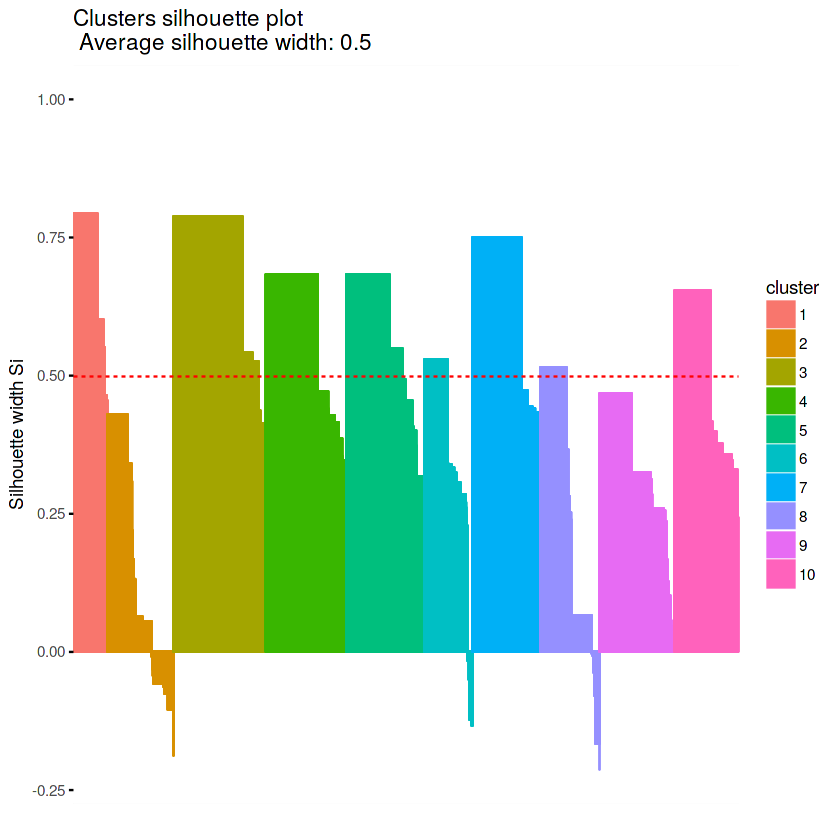

In [132]:
fviz_silhouette(silhouette(pam.res10)) 

In this case we can see that there are less number of clusters where datapoints are poorly assigned (only 2, 6 and 8) and a better global average silhouette of 0.5. This value points that the data seems to be quite unstructured, however with this clustering method we can reveal some of the most salient patterns since some of the clusters have an average over 0.75.

In [12]:
pam10 <- pam(dmatrix, 10)
summary(pam10)

Medoids:
      ID             
 [1,] "10640" "10838"
 [2,] "10584" "10781"
 [3,] "10642" "10840"
 [4,] "10632" "10829"
 [5,] "10645" "10843"
 [6,] "10619" "10816"
 [7,] "10644" "10842"
 [8,] "10630" "10827"
 [9,] "10618" "10815"
[10,] "10639" "10837"
Clustering vector:
    1     2     3     4     5     6     7     8     9    10    11    12    13 
    1     2     3     1     2     1     1     4     5     4     6     7     6 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
    6     2     8     4     4     4     6     4     8     4     9     1    10 
   27    28    29    30    31    32    33    34    35    36    37    38    39 
    2     1     8     1    10     5     6     3     4     8     3     4     1 
   40    41    42    43    44    45    46    47    48    49    50    51    52 
    4     4     8     1     9     3     4     6     5     8     4     4     2 
   53    54    55    56    57    58    59    60    61    62    63    64    65 
    1     2     2  

In [13]:
#display the medoids of the clustering
medoids<-pam10$medoids
medoids

[1] "10838" "10781" "10840" "10829" "10843" "10816" "10842" "10827" "10815"
[10] "10837"

In [21]:
data_demographic[c(medoids),]

wid   country gender marital parenthood age          
10838 13833 USA     m      married y          [31.00,37.00]
10781 13749 USA     f      married y          [26.00,30.00]
10840 13835 USA     m      single  n          [18.00,25.00]
10829 13819 USA     m      single  n          [26.00,30.00]
10843 13838 USA     f      married y          [38.00,65.00]
10816 13798 USA     m      married y          [38.00,65.00]
10842 13837 USA     f      single  n          [18.00,25.00]
10827 13816 USA     m      single  n          [31.00,37.00]
10815 13797 USA     f      single  n          [26.00,30.00]
10837 13832 USA     f      married y          [31.00,37.00]

### Hierarchical Clustering

We apply Hierarchical Agglomerative Clustering where each object is initially considered as a single-element cluster (leaf). At each step of the algorithm, the two clusters that are the most similar are combined into a new bigger cluster (nodes). This procedure is iterated until all points are member of just one single big cluster (root). 

We are using Ward’s minimum variance method, which minimizes the total within-cluster variance. At each step the pair of clusters with minimum between-cluster distance are merged. 
1. Start with each point in a cluster by itself (sum of squares = 0). 
2. Merge two clusters, in order to produce the smallest increase in the sum of squares (the smallest merging cost).
 3. Keep merging until you’ve reached k clusters. 
 
The merging cost is the increase in sum of squares when you merge two clusters (A and B, say), and has a simple formula: 
$\Delta(A,B) = \sum\limits_{i\in A \cup B} \| x_i - m_{A\cup B}\|^2 - \sum\limits_{i \in A}\|x_i - m_A\|^2 - \sum\limits_{i \in C}\|x_i - m_B\|^2$
$ = \frac{n_A n_B}{n_A + n_B}\|m_A - m_B\|^2$

The ∆ formula tells us that there is a trade-off between separation and balance. If clusters are equally far apart (separated), it’s better to merge the smaller ones. 
This means that Ward’s algorithm will sometimes merge clusters which are further apart but smaller.


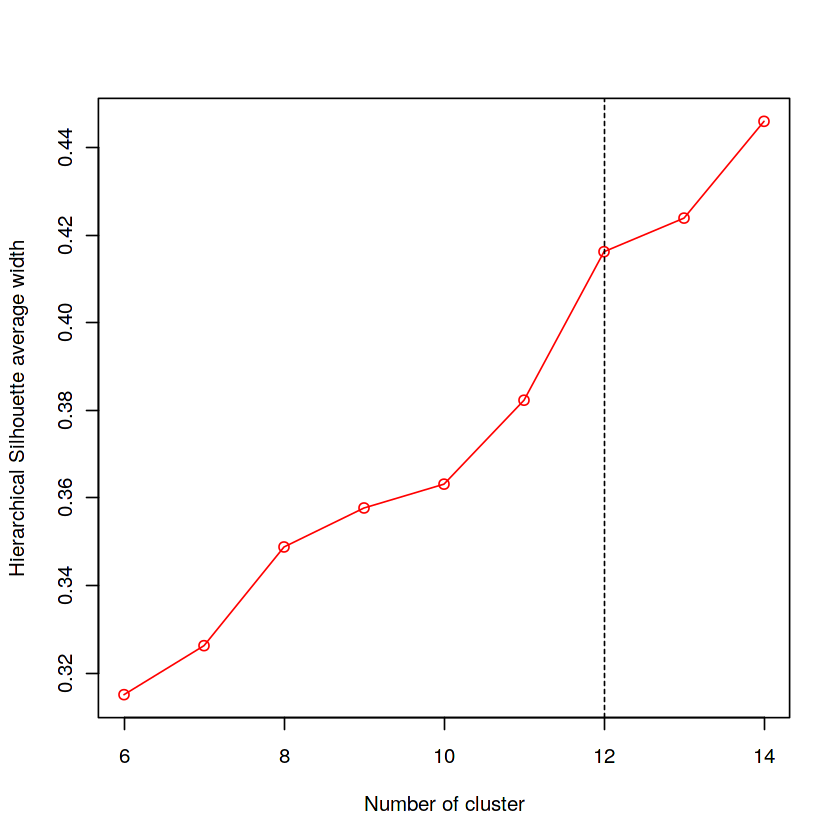

In [162]:
hc <- hclust(dmatrix, method="ward.D2")
ghc6 <- cutree(hc, k=6)
ghc7 <- cutree(hc, k=7)
ghc8 <- cutree(hc, k=8)
ghc9 <- cutree(hc, k=9)
ghc10 <- cutree(hc, k=10)
ghc11 <- cutree(hc, k=11)
ghc12 <- cutree(hc, k=12)
ghc13 <- cutree(hc, k=13)
ghc14 <- cutree(hc, k=14)
mghc6 <- mean(silhouette(ghc6, dmatrix)[, 3])
mghc7 <- mean(silhouette(ghc7, dmatrix)[, 3])
mghc8 <- mean(silhouette(ghc8, dmatrix)[, 3])
mghc9 <- mean(silhouette(ghc9, dmatrix)[, 3])
mghc10 <- mean(silhouette(ghc10, dmatrix)[, 3])
mghc11 <- mean(silhouette(ghc11, dmatrix)[, 3])
mghc12 <- mean(silhouette(ghc12, dmatrix)[, 3])
mghc13 <- mean(silhouette(ghc13, dmatrix)[, 3])
mghc14 <- mean(silhouette(ghc14, dmatrix)[, 3])
ghc_result <- c(mghc6,
mghc7,
mghc8,
mghc9,
mghc10,
mghc11,
mghc12,
mghc13,
mghc14)
plot(6:14, ghc_result, type="o", col="red", xlab = "Number of cluster", ylab = "Hierarchical Silhouette average width")
abline(v = 12, lty =2)

Since hierarchical clustering uses a different approach than k-means and PAM, we compute again the average silhouette for different number of clusters. 
This graph shows that the datapoints are better assigned as we increase the number of clusters. At K=12 we see the highest improvement (with a good average value), so we consider this number as the optimal one. 

In [163]:
silhouette(ghc12, dmatrix)

         cluster neighbor    sil_width
    [1,]       1        4  0.434971658
    [2,]       2        4  0.378094380
    [3,]       3        7  0.402944382
    [4,]       1        4  0.434971658
    [5,]       4        1  0.039006659
    [6,]       2        1  0.257308585
    [7,]       1        4  0.434971658
    [8,]       5        7  0.295642692
    [9,]       6       12  0.623347361
   [10,]       7       10  0.556213894
   [11,]       8        7  0.314906133
   [12,]       9        7  0.738035242
   [13,]       1        2  0.089929214
   [14,]       4        2 -0.318916292
   [15,]       4        1  0.039006659
   [16,]      10        7  0.607773907
   [17,]       7       10  0.556213894
   [18,]       7       10  0.556213894
   [19,]       4       11  0.437814258
   [20,]       1        6  0.523573894
   [21,]       7        3 -0.156889374
   [22,]      10        7  0.607773907
   [23,]       3        7  0.308275792
   [24,]       3       10 -0.084638765
   [25,]       2        1

   cluster size ave.sil.width
1        1 1067          0.39
2        2  432          0.13
3        3  436          0.23
4        4  627          0.17
5        5  329          0.18
6        6 1655          0.58
7        7 2042          0.58
8        8  536          0.04
9        9 1301          0.69
10      10  728          0.53
11      11  595          0.35
12      12  898          0.04


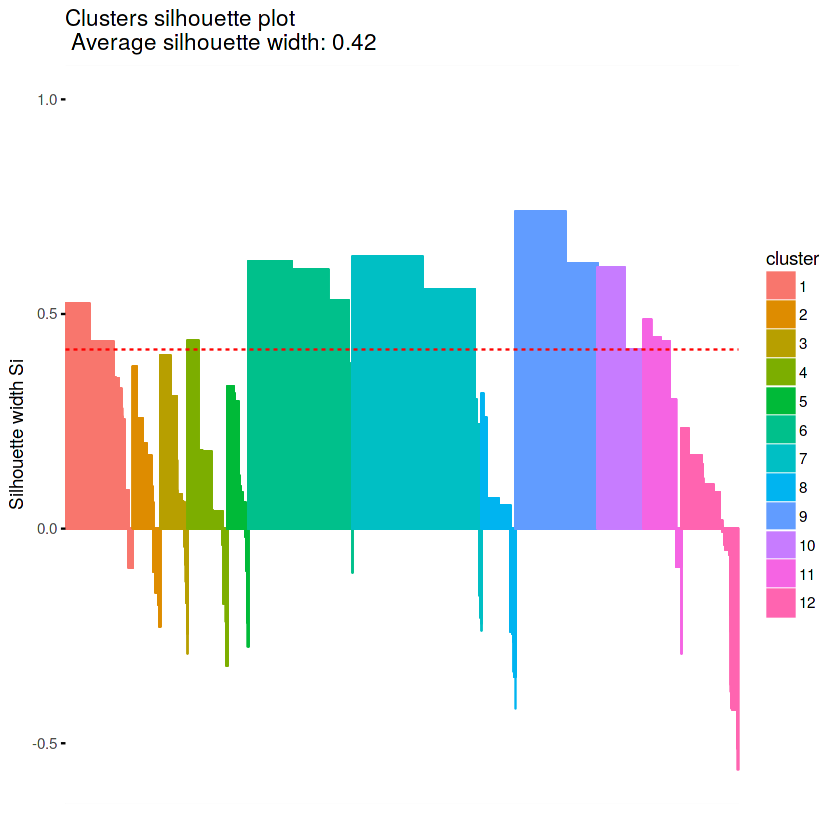

In [164]:
fviz_silhouette(silhouette(ghc12, dmatrix))

We can see that the quality of clusters generated with this method is worse than in the k-means and PAM since the global average Silhouette is lower (0.42) and there are 10 clusters containing datapoints poorly assigned.

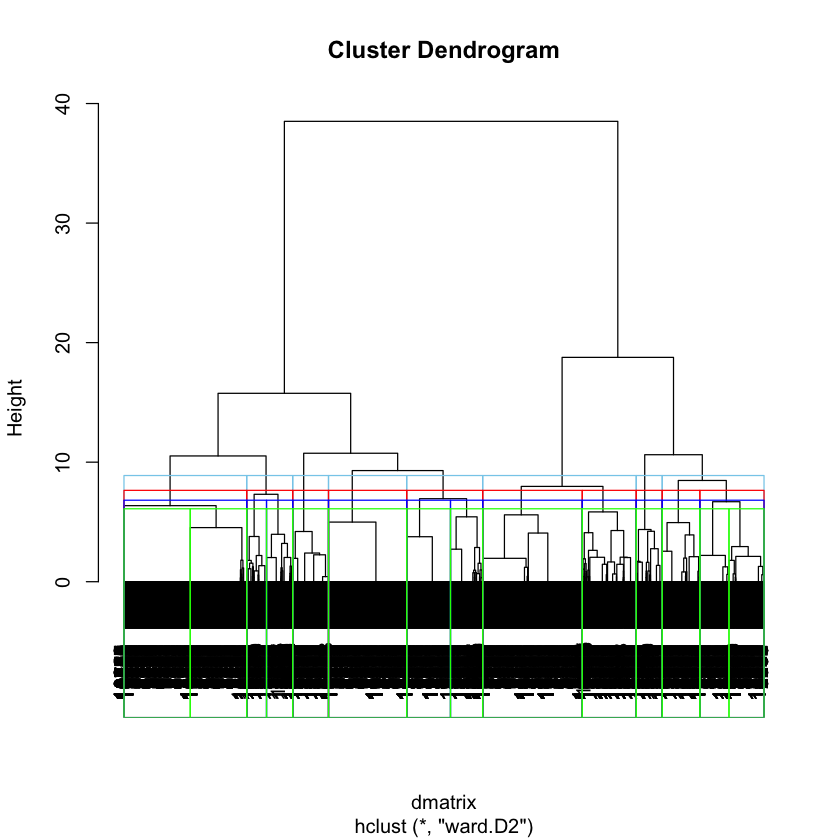

In [14]:
hc <- hclust(dmatrix, method="ward.D2")
plot(hc)
rect.hclust(hc, k=8, border="skyblue")
rect.hclust(hc, k=10, border="red")
rect.hclust(hc, k=12, border="blue")
rect.hclust(hc, k=14, border="green")

In [15]:
ghc12 <- cutree(hc, k=12)

The dendrogram illustrates the arrangement of the clusters produced by this method, where the height shows the distance between clusters. 

In [16]:
# add the results of the clustering to our demographic data
data_demographic_withclusters <- data.frame(data_demographic, km13$cluster, ghc12, pam10$clustering)
dem_wclus <-data.frame(data_demographic_withclusters)
head(dem_wclus)

wid country gender marital parenthood age           km13.cluster ghc12
1 1   USA     m      married y          [31.00,37.00] 2            1    
2 2   IND     m      married y          [26.00,30.00] 7            2    
3 3   IND     m      single  n          [18.00,25.00] 9            3    
4 4   USA     m      married y          [31.00,37.00] 2            1    
5 5   USA     m      married y          [26.00,30.00] 2            4    
6 6   IND     m      married y          [31.00,37.00] 7            2    
  pam10.clustering
1 1               
2 2               
3 3               
4 1               
5 2               
6 1

In [29]:
a <- qplot(dem_wclus$km13, data=dem_wclus, fill=dem_wclus$marital, binwidth = 1)+
            labs(x = "", y = "Count", fill = "Marital Status")+scale_x_continuous(breaks=c(seq(0:12)))
b <- qplot(dem_wclus$ghc12, data=dem_wclus, fill=dem_wclus$marital, binwidth = 1)+
            labs(x = "", y = "Count", fill = "Marital Status")+scale_x_continuous(breaks=c(seq(0:11)))
c <- qplot(dem_wclus$pam10, data=dem_wclus, fill=dem_wclus$marital, binwidth = 1)+
            labs(x = "", y = "Count", fill = "Marital Status")+scale_x_continuous(breaks=c(seq(0:9)))

d <- qplot(dem_wclus$km13, data=dem_wclus, fill=dem_wclus$parenthood, binwidth = 1)+
            labs(x = "", y = "Count", fill = "Parenthood")+scale_x_continuous(breaks=c(seq(0:12)))
e <- qplot(dem_wclus$ghc12, data=dem_wclus, fill=dem_wclus$parenthood, binwidth = 1)+
            labs(x = "", y = "Count", fill = "Parenthood")+scale_x_continuous(breaks=c(seq(0:11)))
f <- qplot(dem_wclus$pam10, data=dem_wclus, fill=dem_wclus$parenthood, binwidth = 1)+
            labs(x = "", y = "Count", fill = "Parenthood")+scale_x_continuous(breaks=c(seq(0:9)))

g <- qplot(dem_wclus$km13, data=dem_wclus, fill=dem_wclus$country, binwidth = 1)+
            labs(x = "", y = "Count", fill = "Country")+scale_x_continuous(breaks=c(seq(0:12)))
h <- qplot(dem_wclus$ghc12, data=dem_wclus, fill=dem_wclus$country, binwidth = 1)+
            labs(x = "", y = "Count", fill = "Country")+scale_x_continuous(breaks=c(seq(0:11)))
i <- qplot(dem_wclus$pam10, data=dem_wclus, fill=dem_wclus$country, binwidth = 1)+
            labs(x = "", y = "Count", fill = "Country")+scale_x_continuous(breaks=c(seq(0:9)))

j <- qplot(dem_wclus$km13, data=dem_wclus, fill=dem_wclus$gender, binwidth = 1)+
            labs(x = "", y = "Count", fill = "Gender")+scale_x_continuous(breaks=c(seq(0:12)))
k <- qplot(dem_wclus$ghc12, data=dem_wclus, fill=dem_wclus$gender, binwidth = 1)+
            labs(x = "", y = "Count", fill = "Gender")+scale_x_continuous(breaks=c(seq(0:11)))
l <- qplot(dem_wclus$pam10, data=dem_wclus, fill=dem_wclus$gender, binwidth = 1)+
            labs(x = "", y = "Count", fill = "Gender")+scale_x_continuous(breaks=c(seq(0:9)))

m <- qplot(dem_wclus$km13, data=dem_wclus, fill=as.character(dem_wclus$age), binwidth = 1)+
            labs(x = "", y = "Count", fill = "Age")+scale_x_continuous(breaks=c(seq(0:12)))
n <- qplot(dem_wclus$ghc12, data=dem_wclus, fill=as.character(dem_wclus$age), binwidth = 1)+
            labs(x = "", y = "Count", fill = "Age")+scale_x_continuous(breaks=c(seq(0:11)))
o <- qplot(dem_wclus$pam10, data=dem_wclus, fill=as.character(dem_wclus$age), binwidth = 1)+
            labs(x = "", y = "Count", fill = "Age")+scale_x_continuous(breaks=c(seq(0:9)))

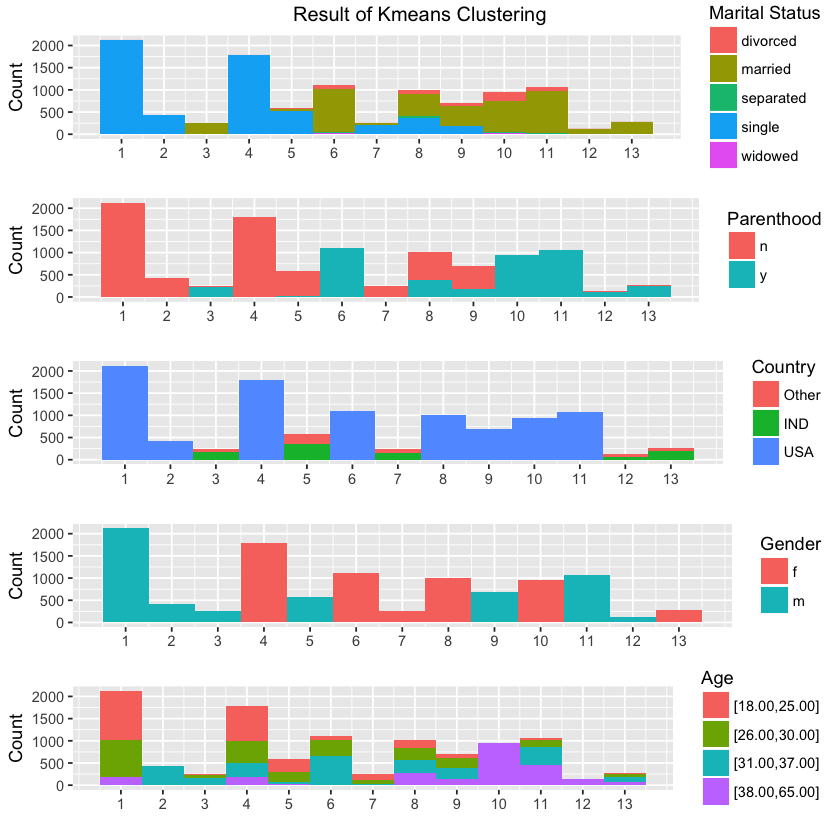

In [30]:
grid.arrange(a,d,g,j,m, ncol=1, nrow = 5, top=("Result of Kmeans Clustering"))

The plots given above show the clustering for each of the demographic variables for the k-means clustering given k=13.
As can be seen, the clusters are very unbalanced in terms of the number of workers per cluster.

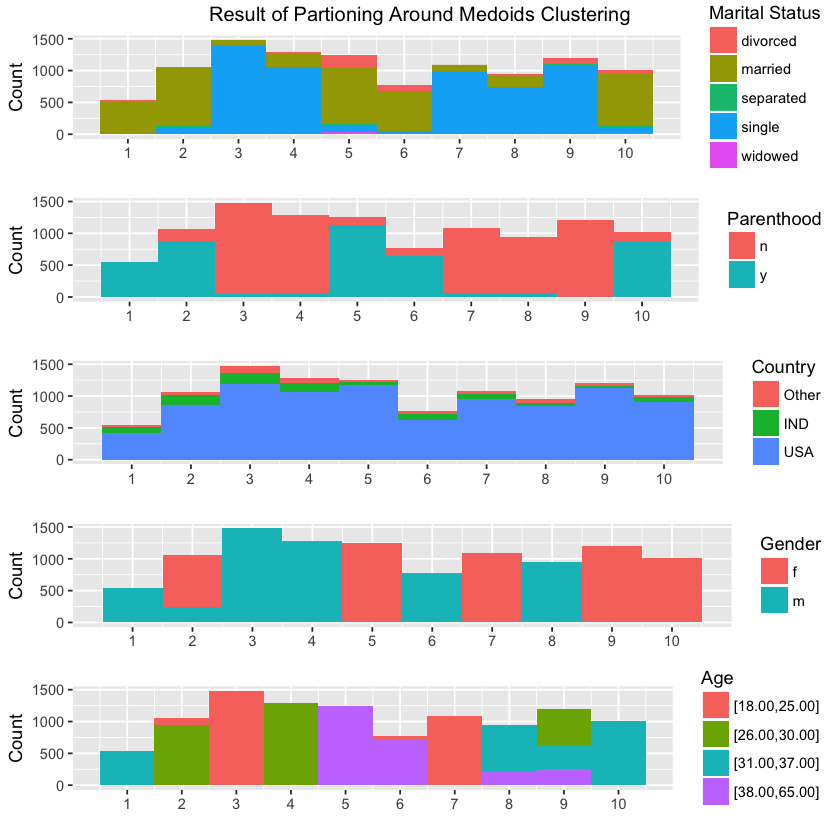

In [31]:
grid.arrange(c,f,i,l,o, ncol=1, nrow = 5, top=("Result of Partioning Around Medoids Clustering"))

The plots given above show the clustering for each of the demographic variables for the partitioning around medoids clustering given k=10. As can be seen above, the number of workers per cluster is a lot more balanced than for the k-means clustering. Also, the clusters are cleaner according to the number of different categories for each variable per cluster.

Since PAM is the clustering that we will continue to use in the subsequent steps of the analysis, we would like to add a few additional comments on the clusters that we have obtained. <br>
For the Marital Status we don't have any cluster that represents a single class. We have mostly single people in clusters 3,4,7,8,9 and maried people in 1,2,5,6,10.
For the variable Parenthood only cluster 1 is completely clean. The other clusters 2,5,6,10 are composed mainly of people having a child and 3,4,7,8,9 do not have a child.
For the country, as we can expect all the clusters are mainly composed of people living in the USA.
For the gender variable, we only have one cluster that has both female and mal members. The Male are represented in cluster 1,3,4,6,8 and the Female in clusters 5,7,9,10.
Finally for the age variable, cluster 1 and 10 are only composed of the age range 31;37. Cluster 3&7 are only composed of 18;25, cluster 5&6 38;65 and finally cluster 4 only composed of 26;30. Clusters 2,8&9 is composed of more than one range.  
<br>
To summarize we have:<br>
Cluster 1:Married with kids living in the USA, male in 31;37.<br>
Cluster 2:Married mainly with kids living in the USA, mainly female in 26;30.<br>
Cluster 3:Single without kids living in the USA, male in 18;25.<br>
Cluster 4:Single without kids living in the USA male in 26;30.<br>
Cluster 5:Married with kids living in the USA, female in 38;65.<br>
Cluster 6:Married with kids living in USA, male in 38;65.<br>
Cluster 7:Single without kids living in the USA, female 18;25.<br>
Cluster 8:Single whitout kids living in the USA, male mainly in 31;37.<br>
Cluster 9:Single whitout kids living in the USA, female with age in 26;65.<br>
Cluster 10:Married with kids living in the USA, female in 31;37.

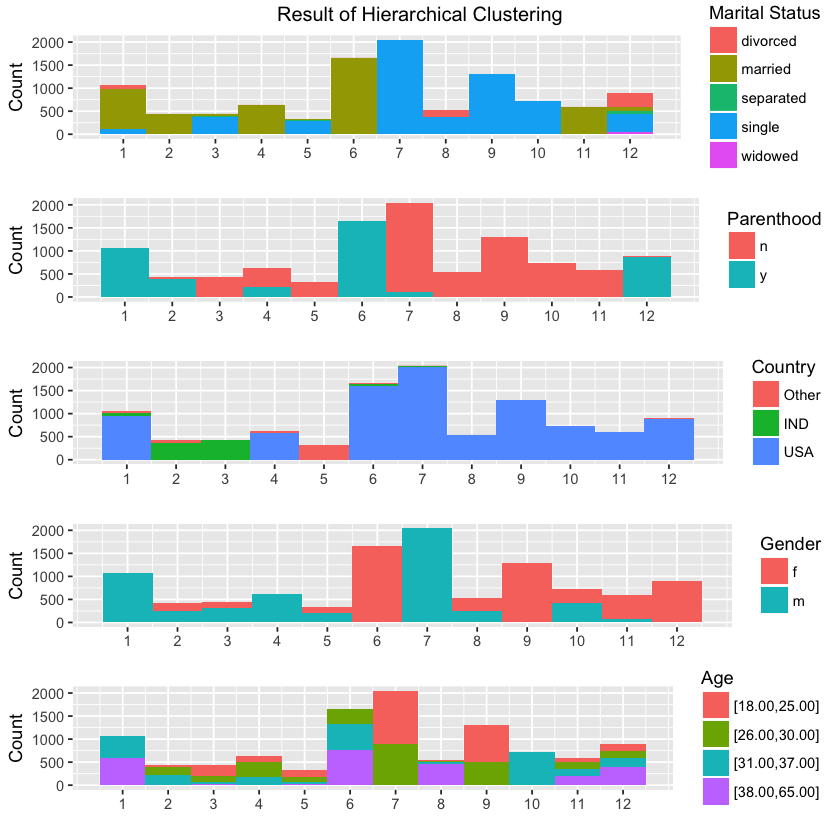

In [32]:
grid.arrange(b,e,h,k,n, ncol=1, nrow = 5, top=("Result of Hierarchical Clustering"))

The plots given above show the clustering for each of the demographic variables for the hierarchical clustering approach given k=12. As can be seen above, the number of workers per cluster is again very unbalanced. However, the clustering of the single variables is cleaner than for k-means. The characteristics of the people in each cluster can be retrieved similarly as in the example of PAM above.

Next, we would like to specifically focus on the age variable in order to analyze the cleanliness of the clustering of each approach:

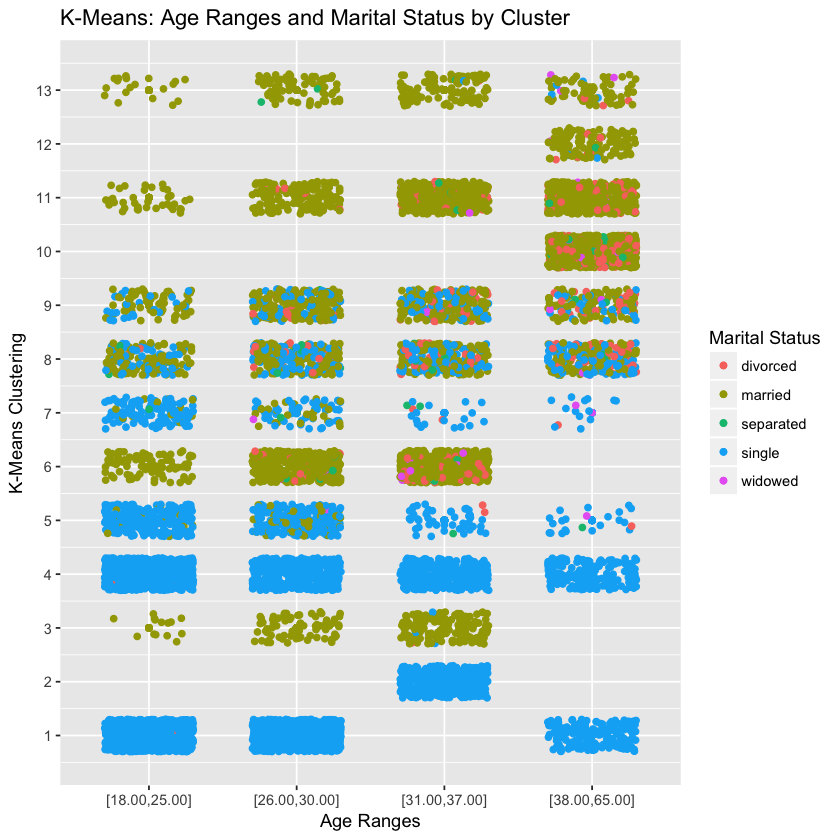

In [36]:
qplot(dem_wclus$age, dem_wclus$km13.cluster, data=dem_wclus, color=dem_wclus$marital) +
        geom_jitter(width = 0.3, height = 0.3)+
        scale_y_continuous(breaks=c(seq(0:12)))+
        labs(title= "K-Means: Age Ranges and Marital Status by Cluster",x = "Age Ranges", y = "K-Means Clustering", color = "Marital Status")

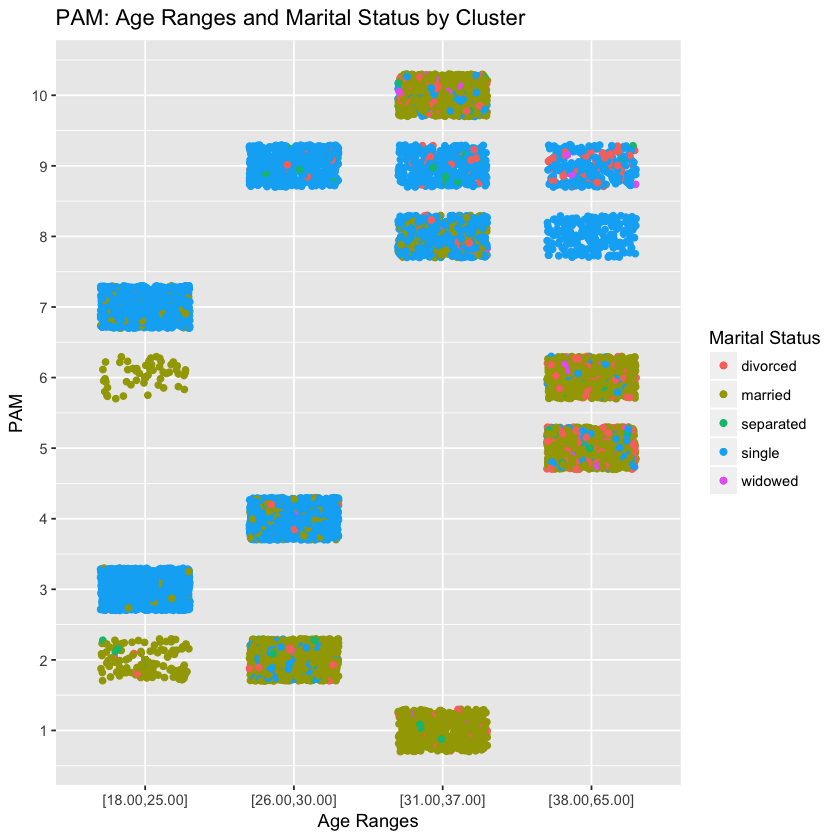

In [38]:
qplot(dem_wclus$age, dem_wclus$pam10.clustering, data=dem_wclus, color=dem_wclus$marital) +
        geom_jitter(width = 0.3, height = 0.3)+
        scale_y_continuous(breaks=c(seq(0:9)))+
        labs(title= "PAM: Age Ranges and Marital Status by Cluster",x = "Age Ranges", y = "PAM", color = "Marital Status")

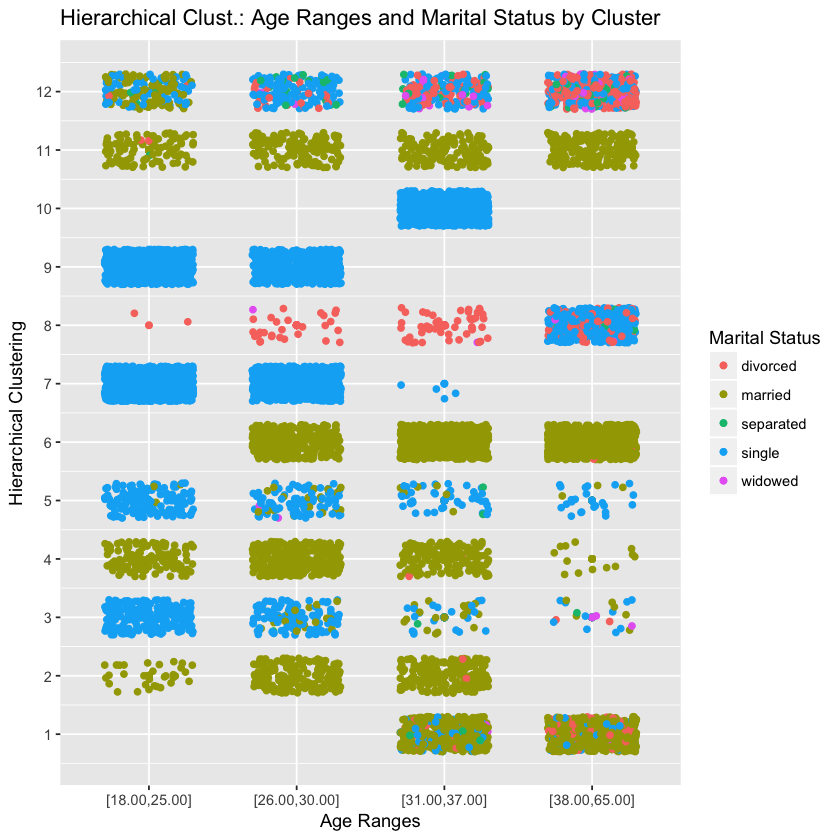

In [39]:
qplot(dem_wclus$age, dem_wclus$ghc12, data=dem_wclus, color=dem_wclus$marital) +
        geom_jitter(width = 0.3, height = 0.3)+
        scale_y_continuous(breaks=c(seq(0:11)))+
        labs(title= "Hierarchical Clust.: Age Ranges and Marital Status by Cluster",x = "Age Ranges", y = "Hierarchical Clustering", color = "Marital Status")

As can be seen in the three plots above, PAM provides - again - the most clean clustering. Both k-means as well as hierarchical clustering have workers of very different age groups within the same cluster. PAM, however, assigns the clusters to the age range in an almost perfect way.

In summary, we can conclude that **the best clustering method for this dataset is PAM** since we get the highest average Silhouette and the less number of clusters with poorly assigned datapoints. 

### 3. Happy Moment and Demographic Data Joined: Correspondence Analysis

In [17]:
summary(data_demographic)

      wid         country     gender        marital     parenthood
 Min.   :    1   Other: 527   f:5379   divorced : 554   n:6350    
 1st Qu.: 2713   IND  : 958   m:5267   married  :4318   y:4296    
 Median : 6028   USA  :9161            separated:  99             
 Mean   : 6375                         single   :5607             
 3rd Qu.: 9946                         widowed  :  68             
 Max.   :13839                                                    
            age      
 [18.00,25.00]:2727  
 [26.00,30.00]:2821  
 [31.00,37.00]:2664  
 [38.00,65.00]:2434  
                     
                     

In [18]:
data_HM <- read.csv("/Users/jacquelineneef/Desktop/Kaggle/data/cleaned_hm.csv")
summary(data_HM)

      hmid             wid        reflection_period
 Min.   : 27673   Min.   :    1   24h:49831        
 1st Qu.: 52942   1st Qu.:  410   3m :50704        
 Median : 78204   Median : 1125                    
 Mean   : 78214   Mean   : 2747                    
 3rd Qu.:103490   3rd Qu.: 3507                    
 Max.   :128766   Max.   :13839                    
                                                   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [19]:
data_joined <- join(x=data_HM, y=data_demographic, by = 'wid')
summary(data_joined)

      hmid             wid        reflection_period
 Min.   : 27673   Min.   :    1   24h:49831        
 1st Qu.: 52942   1st Qu.:  410   3m :50704        
 Median : 78204   Median : 1125                    
 Mean   : 78214   Mean   : 2747                    
 3rd Qu.:103490   3rd Qu.: 3507                    
 Max.   :128766   Max.   :13839                    
                                                   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [20]:
data_joined <- data_joined[complete.cases(data_joined), ]

In [21]:
sapply(data_joined, class)

hmid                   wid     reflection_period 
            "integer"             "integer"              "factor" 
          original_hm            cleaned_hm              modified 
             "factor"              "factor"              "factor" 
         num_sentence ground_truth_category    predicted_category 
            "integer"              "factor"              "factor" 
              country                gender               marital 
             "factor"              "factor"              "factor" 
           parenthood                   age 
             "factor"              "factor"

In [45]:
head(data_joined)

hmid  wid  reflection_period
1 27673 2053 24h              
2 27674    2 24h              
3 27675 1936 24h              
4 27676  206 24h              
5 27677 6227 24h              
6 27678   45 24h              
  original_hm                                                                                                                       
1 I went on a successful date with someone I felt sympathy and connection with.                                                     
2 I was happy when my son got 90% marks in his examination                                                                          
3 I went to the gym this morning and did yoga.                                                                                      
4 We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.
5 I went with grandchildren to butterfly display at Crohn Conservatory\n                                                            
6 I meditated last night.                                                                                                           
  cleaned_hm                                                                                                                        
1 I went on a successful date with someone I felt sympathy and connection with.                                                     
2 I was happy when my son got 90% marks in his examination                                                                          
3 I went to the gym this morning and did yoga.                                                                                      
4 We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.
5 I went with grandchildren to butterfly display at Crohn Conservatory\n                                                            
6 I meditated last night.                                                                                                           
  modified num_sentence ground_truth_category predicted_category country gender
1 True     1                                  affection          USA     m     
2 True     1                                  affection          IND     m     
3 True     1                                  exercise           USA     f     
4 True     2            bonding               bonding            Other   f     
5 True     1                                  affection          USA     f     
6 True     1            leisure               leisure            IND     m     
  marital  parenthood age          
1 single   n          [31.00,37.00]
2 married  y          [26.00,30.00]
3 married  y          [26.00,30.00]
4 married  n          [26.00,30.00]
5 divorced y          [38.00,65.00]
6 single   n          [18.00,25.00]

Why correspondence Analysis - what behind the scenes?

### Correspondence Analysis

In order to further explore what makes people happy, we decided to investigate the relationship between the demographics of a person and the (predicted) category of the happy moment.
At first, we will use the clustering that we have worked on during the data exploration of the demographic data.
Since we have found out that PAM clustering with k=10 fits our data most approriately, we will use this categorical variable
and do a correspondence analysis of it with the category of the happy moment.
The idea behind this is to compare the summarized demographic data,
which is the cluster with the category of the happy moment.
So, we would like to answer the question if the category of the happy moment depends on the demographic group of a person and if the demographics of a person have a similar “behaviour“ as the categories of the happy moments.

Data Preparation for the Correspondence Analysis

In [22]:
#get the joined data including the clustering
data_joined_CA <- join(x=data_HM, y=dem_wclus, by = 'wid')
data_joined_CA <- data_joined_CA[complete.cases(data_joined_CA), ]
head(data_joined_CA)

hmid  wid  reflection_period
1 27673 2053 24h              
2 27674    2 24h              
3 27675 1936 24h              
4 27676  206 24h              
5 27677 6227 24h              
6 27678   45 24h              
  original_hm                                                                                                                       
1 I went on a successful date with someone I felt sympathy and connection with.                                                     
2 I was happy when my son got 90% marks in his examination                                                                          
3 I went to the gym this morning and did yoga.                                                                                      
4 We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.
5 I went with grandchildren to butterfly display at Crohn Conservatory\n                                                            
6 I meditated last night.                                                                                                           
  cleaned_hm                                                                                                                        
1 I went on a successful date with someone I felt sympathy and connection with.                                                     
2 I was happy when my son got 90% marks in his examination                                                                          
3 I went to the gym this morning and did yoga.                                                                                      
4 We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.
5 I went with grandchildren to butterfly display at Crohn Conservatory\n                                                            
6 I meditated last night.                                                                                                           
  modified num_sentence ground_truth_category predicted_category country gender
1 True     1                                  affection          USA     m     
2 True     1                                  affection          IND     m     
3 True     1                                  exercise           USA     f     
4 True     2            bonding               bonding            Other   f     
5 True     1                                  affection          USA     f     
6 True     1            leisure               leisure            IND     m     
  marital  parenthood age           km13.cluster ghc12 pam10.clustering
1 single   n          [31.00,37.00] 1            10    8               
2 married  y          [26.00,30.00] 7             2    2               
3 married  y          [26.00,30.00] 3             6    2               
4 married  n          [26.00,30.00] 5             5    2               
5 divorced y          [38.00,65.00] 3            12    5               
6 single   n          [18.00,25.00] 9             3    3

In [23]:
data_joined_CA <- data_joined_CA[,-c(3,4,5,6,7,8,10,11,12,13,14,15,16)]
head(data_joined_CA)

hmid  wid  predicted_category pam10.clustering
1 27673 2053 affection          8               
2 27674    2 affection          2               
3 27675 1936 exercise           2               
4 27676  206 bonding            2               
5 27677 6227 affection          5               
6 27678   45 leisure            3

data_joined_CA is the dataset that we will use for the following Correpsondence Analysis, it contains the following variables:

In [24]:
summary(data_joined_CA)

      hmid             wid               predicted_category pam10.clustering
 Min.   : 27673   Min.   :    1   achievement     :33624    Min.   : 1.000  
 1st Qu.: 52942   1st Qu.:  409   affection       :33792    1st Qu.: 3.000  
 Median : 78244   Median : 1121   bonding         :10605    Median : 5.000  
 Mean   : 78217   Mean   : 2725   enjoy_the_moment:11007    Mean   : 5.304  
 3rd Qu.:103480   3rd Qu.: 3440   exercise        : 1189    3rd Qu.: 8.000  
 Max.   :128766   Max.   :13839   leisure         : 7386    Max.   :10.000  
                                  nature          : 1824                    

In the following, we will show and discover a potential dependency between the Happy Moment Category and the Clustering. This helps to show what happens behind the scenes during the Correspondence Analysis that we will carry out afterards using the ca package.
<br> For this, we first transform the contingency table of the Happy Moment (Predicted) Category and the Clustering into a matrix. 

In [42]:
Contingency_Matrix <- as.matrix(cont_table)
Contingency_Matrix

                  B
A                     1    2    3    4    5    6    7    8    9   10
  achievement      2161 2861 5644 5495 2713 2367 2591 4432 3464 1896
  affection        2724 4684 3385 3763 4378 2957 2940 2598 2758 3605
  bonding           520  908 1913 1886  722  579 1024 1209 1310  534
  enjoy_the_moment  788 1124 1752 1699  863  727  973 1395 1092  594
  exercise           50   81  242  260   65   73   67  166  143   42
  leisure           378  800 1182 1435  471  470  400 1061  792  397
  nature             78  125  186  231  293  163   99  240  286  123

We then divide each value of the contingency matrix $n_{ij}$ by the total number of data points n, which corresponds to the count of all happy moments, in order to get a Frequency Matrix. The frequency for each combination is denoted by $f_{ij}$.

Similarly, we saw this in class (fillatre_data_valorization_2018_lecture9_JALON.pdf):

<img src="images/FrequencyTable.png" alt="Drawing" style="width: 500px;"/>

In [43]:
n = sum(Contingency_Matrix)
Frequency_Matrix = Contingency_Matrix / n
Frequency_Matrix

                  B
A                             1            2            3            4
  achievement      0.0217345389 0.0287748801 0.0567652650 0.0552666781
  affection        0.0273969847 0.0471099400 0.0340450783 0.0378468625
  bonding          0.0052299677 0.0091323282 0.0192402466 0.0189686906
  enjoy_the_moment 0.0079254126 0.0113047764 0.0176209681 0.0170879137
  exercise         0.0005028815 0.0008146680 0.0024339465 0.0026149839
  leisure          0.0038017842 0.0080461042 0.0118881189 0.0144326994
  nature           0.0007844952 0.0012572038 0.0018707192 0.0023233126
                  B
A                             5            6            7            8
  achievement      0.0272863508 0.0238064107 0.0260593199 0.0445754171
  affection        0.0440323051 0.0297404126 0.0295694329 0.0261297233
  bonding          0.0072616090 0.0058233679 0.0102990133 0.0121596749
  enjoy_the_moment 0.0086797349 0.0073118972 0.0097860742 0.0140303942
  exercise         0.0006537460 0.000

Having this Frequency Matrix, we can continue and compute the masses of the rows $f_{i+}$ as well as the masses of the columns $f_{+j}$. 
<br> Further, we compute the expected frequencies under the assumption of independence of the two variables happy moment category and clustering. For this, we use the formulas given in class (fillatre_data_valorization_2018_lecture9_JALON.pdf):

|<img src="images/RowMass.png" alt="Drawing" style="width: 100px;"/>|<img src="images/ColumnMass.png" alt="Drawing" style="width: 100px;"/>|
|------------|
<center><img src="images/RelativeFrequencies.png" alt="Drawing" style="width: 300px;"/> </center>

In R, we used the outer product (%o%) of the array of row.masses and column.masses in order to compute the expected frequency $f^*_{ij}$ for each combination of the two variables.

In [44]:
column.masses = colSums(Frequency_Matrix)
row.masses = rowSums(Frequency_Matrix)
Expected_Frequencies = row.masses %o% column.masses
Expected_Frequencies

1            2           3           4           5          
achievement      0.0227850866 0.035995607 0.048651721 0.050233310 0.032329041
affection        0.0228989307 0.036175457 0.048894806 0.050484297 0.032490571
bonding          0.0071864098 0.011353004 0.015344739 0.015843572 0.010196570
enjoy_the_moment 0.0074588225 0.011783359 0.015926407 0.016444148 0.010583088
exercise         0.0008057182 0.001272864 0.001720405 0.001776333 0.001143208
leisure          0.0050050752 0.007906958 0.010687057 0.011034476 0.007101544
nature           0.0012360218 0.001952652 0.002639208 0.002725005 0.001753752
                 6           7           8           9           10          
achievement      0.024951694 0.027529854 0.037757463 0.033485472 0.0244585099
affection        0.025076363 0.027667405 0.037946116 0.033652780 0.0245807151
bonding          0.007869757 0.008682908 0.011908693 0.010561308 0.0077142070
enjoy_the_moment 0.008168073 0.009012048 0.012360112 0.010961652 0.0080066268
exercise         0.000882333 0.000973501 0.001335166 0.001184101 0.0008648932
leisure          0.005481002 0.006047332 0.008293975 0.007355570 0.0053726670
nature           0.001353554 0.001493411 0.002048228 0.001816485 0.0013268000

In the next step, we compute the residual for each entry in our observed frequency matrix minus each entry of the expected frequency matrix. The resulting Residuals matrix contains for each combination of the two variables happy moment category and clustering the residual value: $$residual = f_{ij} - f^*_{ij}$$

This shows the deviation from our observed frequencies in the data from the expected frequencies given independence of the variables happy moment category and clustering. As can be seen in the output below, the variables are dependent:

In [45]:
Residuals = Frequency_Matrix - Expected_Frequencies
Residuals

                  B
A                              1             2             3             4
  achievement      -1.050548e-03 -7.220727e-03  8.113544e-03  5.033368e-03
  affection         4.498054e-03  1.093448e-02 -1.484973e-02 -1.263743e-02
  bonding          -1.956442e-03 -2.220676e-03  3.895508e-03  3.125119e-03
  enjoy_the_moment  4.665901e-04 -4.785821e-04  1.694562e-03  6.437654e-04
  exercise         -3.028367e-04 -4.581959e-04  7.135416e-04  8.386513e-04
  leisure          -1.203291e-03  1.391462e-04  1.201062e-03  3.398223e-03
  nature           -4.515267e-04 -6.954487e-04 -7.684891e-04 -4.016921e-04
                  B
A                              5             6             7             8
  achievement      -5.042691e-03 -1.145283e-03 -1.470534e-03  6.817954e-03
  affection         1.154173e-02  4.664050e-03  1.902028e-03 -1.181639e-02
  bonding          -2.934961e-03 -2.046389e-03  1.616105e-03  2.509818e-04
  enjoy_the_moment -1.903353e-03 -8.561760e-04  7.740262e-04

In order to have a more clear and unbiased view on the residuals, we subsequently divide the residual by the expected frequency matrix and like this normalize the residuals by the row and column masses and get the indexed residuals.
<br> As a result, we can easily interpret the indexed residuals: The larger the observed proportion relative to the expected proportion, the larger the absolute value of the residual.

Source: https://www.displayr.com/math-correspondence-analysis/
<br><br> In our data below, we can see that the people in cluster 9 who are happy because of nature is ~60% more likely then expected given independence of the variables. Similarly, people in cluster 5 are ~43% less likely to like exercising than expected.
<br> It is exactly this relative tendency that associates the variables that we would like to assess and that we will visualize in the following using the Correspondence Analysis.

In [46]:
Indexed_Residuals = Residuals / Expected_Frequencies
Indexed_Residuals

                  B
A                            1           2           3           4           5
  achievement      -0.04610681 -0.20060023  0.16676787  0.10019981 -0.15598021
  affection         0.19643074  0.30226248 -0.30370767 -0.25032407  0.35523333
  bonding          -0.27224193 -0.19560249  0.25386602  0.19724839 -0.28783809
  enjoy_the_moment  0.06255546 -0.04061509  0.10639950  0.03914860 -0.17984858
  exercise         -0.37585929 -0.35997240  0.41475209  0.47212517 -0.42814790
  leisure          -0.24041417  0.01759795  0.11238470  0.30796416 -0.33294166
  nature           -0.36530639 -0.35615590 -0.29118166 -0.14740969  0.68033162
                  B
A                            6           7           8           9          10
  achievement      -0.04590000 -0.05341597  0.18057235  0.04044019 -0.22034225
  affection         0.18599386  0.06874617 -0.31139926 -0.17573097  0.47504890
  bonding          -0.26003206  0.18612489  0.02107551  0.24752494 -0.30378138
  enjoy_the_

In the following, we leverage the function ca() from the ca package in order to carry out a correspondence analysis based on the aforementioned variables happy moment (predicted) category and demographics clustering.
In the first step, we create a contingency table of the two categorical variables of which we would like to analyze the interactions using Correspondence Analysis.
<br> In the output below, you can see:
<br> 1) The Contingency Table of the Happy Moment Category and the Cluster
<br> 2) The Frequency Table of the Observed Conditional Row Profiles, where the Happy Moment Category is fixed
<br> 3) The Frequency Table of the Observed Conditional Column Profiles, where the Cluster is fixed

In [33]:
# Correspondence Analysis
A <- data_joined_CA$predicted_category
B <- data_joined_CA$pam10.clustering
cont_table <- with(data_joined_CA, table(A,B)) # create a 2 way table
cat("1) Contingency Table")
print(cont_table)
cat("\n 2) Frequency Table of Row Profiles - Happy Moment Category is fixed")
prop.table(cont_table, 1) # row percentages
cat("\n 3) Frequency Table of Column Profiles - Clustering is fixed")
prop.table(cont_table, 2) # column percentages

1) Contingency Table                  B
A                     1    2    3    4    5    6    7    8    9   10
  achievement      2161 2861 5644 5495 2713 2367 2591 4432 3464 1896
  affection        2724 4684 3385 3763 4378 2957 2940 2598 2758 3605
  bonding           520  908 1913 1886  722  579 1024 1209 1310  534
  enjoy_the_moment  788 1124 1752 1699  863  727  973 1395 1092  594
  exercise           50   81  242  260   65   73   67  166  143   42
  leisure           378  800 1182 1435  471  470  400 1061  792  397
  nature             78  125  186  231  293  163   99  240  286  123

 2) Frequency Table of Row Profiles - Happy Moment Category is fixed

                  B
A                           1          2          3          4          5
  achievement      0.06426957 0.08508803 0.16785629 0.16342493 0.08068641
  affection        0.08061080 0.13861269 0.10017164 0.11135772 0.12955729
  bonding          0.04903347 0.08561999 0.18038661 0.17784064 0.06808109
  enjoy_the_moment 0.07159081 0.10211683 0.15917144 0.15435632 0.07840465
  exercise         0.04205214 0.06812447 0.20353238 0.21867115 0.05466779
  leisure          0.05117790 0.10831302 0.16003249 0.19428649 0.06376929
  nature           0.04276316 0.06853070 0.10197368 0.12664474 0.16063596
                  B
A                           6          7          8          9         10
  achievement      0.07039615 0.07705805 0.13181061 0.10302165 0.05638829
  affection        0.08750592 0.08700284 0.07688210 0.08161695 0.10668205
  bonding          0.05459689 0.09655823 0.11400283 0.12352664 0.05035361
  enjoy_the_moment 0.06604888 0.08839829 0.12673753 0.09920959 0.0539656


 3) Frequency Table of Column Profiles - Clustering is fixed

                  B
A                            1           2           3           4           5
  achievement      0.322585461 0.270339223 0.394574944 0.372063105 0.285428722
  affection        0.406627855 0.442596617 0.236647092 0.254790439 0.460599684
  bonding          0.077623526 0.085797978 0.133738814 0.127699912 0.075960021
  enjoy_the_moment 0.117629497 0.106208070 0.122483221 0.115038256 0.090794319
  exercise         0.007463801 0.007653784 0.016918345 0.017604442 0.006838506
  leisure          0.056426332 0.075592932 0.082634228 0.097162977 0.049552867
  nature           0.011643529 0.011811396 0.013003356 0.015640869 0.030825881
                  B
A                            6           7           8           9          10
  achievement      0.322655398 0.320113664 0.399243311 0.351853733 0.263662912
  affection        0.403080698 0.363232024 0.234032970 0.280142204 0.501321096
  bonding          0.078925845 0.126513467 0.108909107 0.133062468 0.074259491
  enjoy_the_

As can be observed in the resulting Observed Conditional Column Profiles, the fact that achievement and affection are the majority classes, leads to a strong tendency of each cluster having the largest observed frequency in these two categories. <br> However, in the Observed Conditional Row Profiles, this is not observable, because the predicted category is the fixed variable. Here, one can get an idea which happy moment category is present most often in which clusters: <br>
<br>achievement --> clusters 3,4,8
<br>affection --> cluster 2,5,4
<br>bonding --> cluster 3,4,9
<br>enjoy_the_moment --> cluster 3,4,8
<br>exercise --> cluster 4,3,8
<br>leisure --> cluster 4,3,8
<br>nature --> cluster 5,9,8


Next, we use the ca() method, which carries out a singular value decomposition behind the scenes in order to find the principal components in the data. The principal components are the axis within the multidimensional data cloud that approximate and represent the data best even though it significantly reduces the dimensionality.
<br> In our case, our data is represented by a (7x10) matrix. The ca() function will carry out the singular value decomposition to handle the fact that we are not in a (nxn), but a (nxm) matrix.

In [22]:
# compute a simple correspondence analysis based on the singular value decomposition
ca_result <- ca(cont_table)
print(ca_result)


 Principal inertias (eigenvalues):
           1        2        3        4       5        6    
Value      0.043122 0.002673 0.001923 0.00125 0.000306 2e-05
Percentage 87.48%   5.42%    3.9%     2.54%   0.62%    0.04%


 Rows:
        achievement affection   bonding enjoy_the_moment exercise  leisure
Mass       0.338178  0.339867  0.106661         0.110704 0.011959 0.074286
ChiDist    0.141231  0.283035  0.229428         0.116182 0.372798 0.235733
Inertia    0.006745  0.027226  0.005614         0.001494 0.001662 0.004128
Dim. 1     0.657432 -1.362068  0.963915         0.460952 1.723791 0.932574
Dim. 2     0.185818 -0.141892 -0.733711        -0.794632 0.529414 0.279684
           nature
Mass     0.018345
ChiDist  0.363460
Inertia  0.002423
Dim. 1  -0.171098
Dim. 2   6.786831


 Columns:
                1         2         3         4         5         6         7
Mass     0.067376  0.106440  0.143864  0.148541  0.095598  0.073783  0.081406
ChiDist  0.174935  0.229832  0.231154  0.19779

With these results of the Observed Conditional Row Profiles and the Observed Conditional Column Profiles given above, we can continue and find <br>1) The Center of Mass, which corresponds to the average row (column) profile (see Mass in the table above). <br>2) The Chi-Square Distance between the rows (columns), which gives each column (row) the same relative importance according to the average frequency (see ChiDist in the table above).
<br> 3) The Inertia - i.e. the dispersion of the row (column) profile around the Center of Mass.
<br> 4) and 5) The coordinates of the row (column) profile according to the two dimensions, which are the largest eigenvectors of the data that are centered in the Center of Mass and which show the principal dispersion of the data.

Moreover, the plot shows the principal inertias (eigenvalues) that have been distinguished in the data. The eigenvalues show the magnitude of the dispersion of the data along the direction in which the two dimensions (eigenvectors) point. As observable from the output above, 87% of our data can be represented correctly by just the first, largest eigenvector and its eigenvalue. Adding the second dimension to it, we get to an cumulated 92.9% that can be represented with these two principal components.
Taking into account that the goal of a Correspondence Analysis is inter alia to summarize data in a two-dimensional graphical form, the fact that we can correctly represent 92.9% of that initial data by means of the two dimensions, is a very good approximation. In the following we will plot the row and column profiles for all categories along these two dimensions and further interpret the results.

Source: Nenadic, Oleg, and Michael Greenacre. "Correspondence analysis in R, with two-and three-dimensional graphics: The ca package." Journal of statistical software 20.3 (2007).

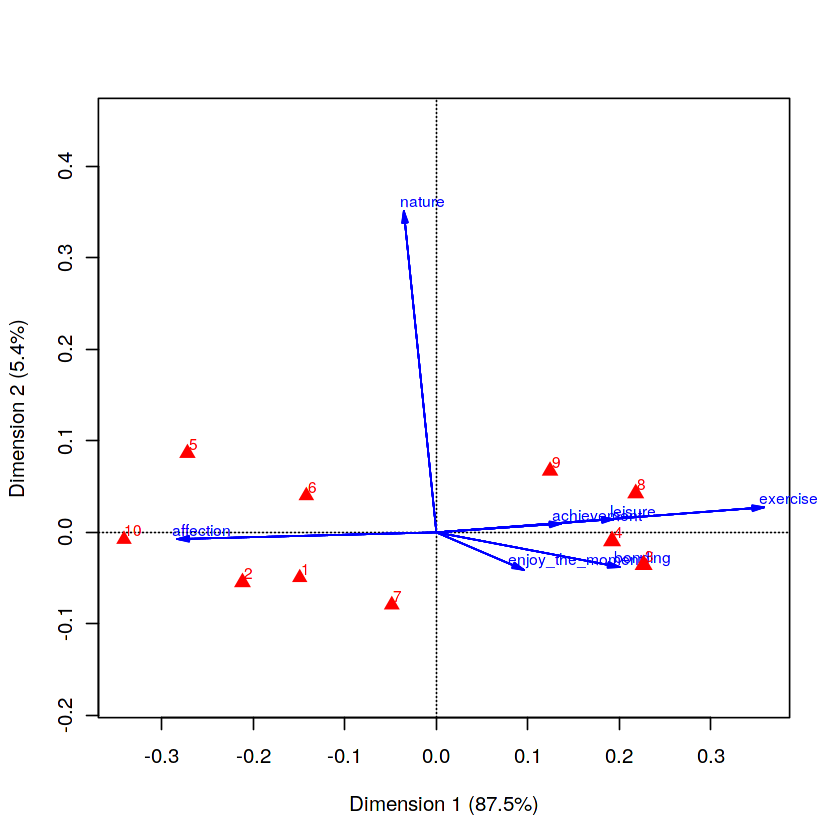

In [60]:
plot(ca_result, arrow=c(T,F), mass = TRUE) #symmetric plot - the rows and columns are in the principal coordinates

Interpretation of the plot above:
The x-axis represents the first dimension - the first principal component - and the y-axis represents the second dimension - the second principal component.
The row profiles are the conditional frequencies given the happy comment categories are fixed, these are represented by blue dots and the corresponding happy moment category label. The point (0,0) is the center of mass.
The column profiles are the conditional frequencies given the clusters are fixed, represented by red traingles and the corresponding cluster numbers.
The closer the points of one color are together, the more similar are the corresponding row/colum profiles.
<br>
In the case of the comment categories (blue dots), the closer the dots are together, the more similar are their column profiles. In the case of the clusters (red triangles), the closer these traingles are together, the more similar are their row profiles.
The closer the points are to the center of mass, the more these row profiles tend to be independent. The further the points are away from the center of mass, the stronger the associations between that point and the other points on the chart.
<br> However, it is not possible to directly compare the distance between red and blue points directly from this chart!
<br> Instead, the $\cos$ of the angle between the vector from the center of mass until a red and a blue point is to be interpreted: The smaller the angle (the larger the cosine), the more the row/column profiles are related. If the angle is 90°, which means that the $\cos(90°)=0$, the row/column profiles are not related. If the angle is 180°, which means that the $\cos(180°) = -1$, the row/column profiles are inversely related.

Source: Robert I. Kabacoff, Ph.D.Correspondence Analysis.Quick-R. https://www.statmethods.net/advstats/ca.html (2017).

<br>
Putting all this together, we can retrieve from the plot above the following information (the clusters are mentioned in descending order of the strength of the observed relation): <br>
- People in cluster 10, 6, 2, 5, 1 are likely to be happy due to affection
- People in cluster 9, 5 and 6 are likely to be happy due to activities involving nature
- People in cluster 8 and 9 are likely to be happy due to achievement, leisure or exercise
- People in cluster 3 are likely to be happy due to bonding or enjoy_the_moment
...
<br> In contrast: <br>
- People in cluster 10 are relatively unlikely to like activities that consist in achievement, leisure or exercise
- People in cluster 5 and 6 are relatively unlikely to be happy because of bonding or enjoy_the_moment
...

All these insight can be also directly read in the indexed residuals table above. The higher the value of the indexed residual, the more likely a person in a cluster is to like a certain category of activities/moments.

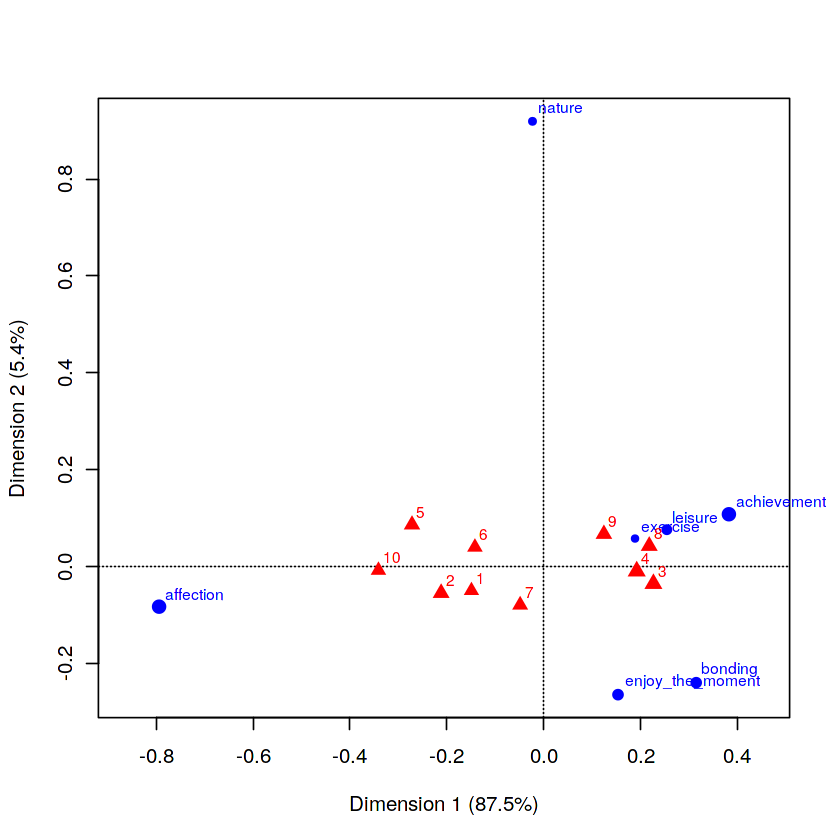

In [63]:
plot(ca_result, mass = TRUE, map ="colgreen") # asymmetric map

This second graph above, which is a biplot, is asymmetric, with columns (happy moment categories in blue) fixed in the principal coordinates. The red traingles represent the standarized residuals of the clusters in terms of these coordinates.
The interpretation of this different view of the results of the correspondence analysis is consistent with the interpretation of the symmetric plot above:
<br> As can be seen in the plot, affection is represented mostly by Dimension1, therefore, all triangles in the left part of the plot (negative values for dim1) are likely to be related to affection.
<br>
- Cluster 10 is again the cluster which is most likely related to the category affection, moreover, cluster 5,2,1,6 and 7 are likely to be also related to affection.
- Cluster 5,9,6 and 8 are in the negative part of dim2, which is the dimension that mostly represents the category nature - therefore these clusters are likely to be related to nature (again).
- Cluster 10 is again clearly inversely related to the categories achievement, exercise and leisure, because it is located in the opposite quadrant of the plot


A bit less clear due to the fact that the categories are closer to the center of mass:
- Clusters 9,8 are related to exercise, leisure and achievement
- Clusters 4,3 are related to bonding and enjoy_the_moment

Taking the results of the Correspondence Analysis into account, we have gotten fairly informative results in terms of which groups of people (cluster) prefers which type of activities. Taking into account the characteristics of the PAM10 clustering:
<img src="images/PAM10Clustering.png" alt="Drawing" style="width: 400px;"/>

We can see that cluster10 is composed of married, middle-aged mothers. This group of people apparently is most happy doing activities that involve affection and does not care much about exercise, leisure or achievement.
<br>
Moreover, people in cluster8 and cluster9, which are single persons that have no kids enjoy mostly activities that involve exercise, leisure or achievement.
<br> 
Another insight that we can clearly gain from the correspondence analysis, people in cluster 3 and cluster4 are single, young males with no kids. This group is also more likely to enjoy exercise, leisure and achievement, but also bonding and enjoy_the_moment - so a broad variety of activities, but least likely affection and nature.
<br>
Last but not least, considering our two clusters5 and cluster6 that represent the oldest age group, which is mainly married and has kids, are the two clusters that can be associated with the happy moment category nature.

<br>
All in all, we can clearly see that the demographic information of a person determines what makes him/her happy. Middle-aged parents tend to like affection, young singles prefer exercise, leisure or achievement, whereas the older age group can be associated with being happy in the nature.

In the next step of our analysis, we will go even more into detail when analysing the relationship between the demographic information and what makes this person happy. For this, we will use a classification tree that takes in the happy moment (predicted) category as the target and the demographic information of the worker as the predictor variables. We chose a decision tree, because it provides an easy to interpret, visual tool for exploring the data and yields an easy to understand set of decision rules that allows an even more fine-grained analysis of what determines what makes people happy.

### 4. Happy Moment and Demographic Data Joined: Classification using a Decision Tree

In order to classify the category of new input data we implement the conditional inference tree. 
Conditional inference trees offer several advantages over traditional approaches. First, variable selection is unbiased (the traditional method is biased towards variables with many possible splits). Second, one does not have to ‘prune’ (i.e. simplify) the resulting tree to
avoid overftting. Tird, the algorithm also returns the p-values that show how confident one can be about every split.
To construct the tree we analyze the relationship between variables and classify members of the population by splitting it into sub-populations based on several dichotomous independent variables. 

Roughly, the algorithm works as follows: 

1) Test the global null hypothesis of independence between any of the input variables and the predicted category.  The global hypothesis of independence is formulated in terms of the joint probability of m partial hypotheses $$H_0 = \cap_j H^j_0 : P(Y|X_j)$$

We consider a significance level of 5%. This means that we assume a risk (error rate) of 5% of considering dependency when there is not.
<img src="images/p-value.png" alt="Drawing" style="width: 500px;"/>
For this level α,  if the null hypothesis is accepted, we stop the recursion since the remaining information is considered independent.  
Otherwise select the input variable with strongest association to the predicted category. This association is measured by a p-value corresponding to a test for the partial null hypothesis of a single input variable and the response $$H^j_0 : P(Y|X_j)$$.
Therefore, the variable with lower p-value is selected for splitting since, as explained in class,  it indicates strong evidence against the null hypothesis of independence.

2) Implement a binary split in the selected input variable. To find the optimal binary split in one selected variable we select the maximum estimator
$$max \space  \hat{P}(Y_i|X_j) =  \dfrac{P(X_j\cap{Yi})}{ P(Xj)} $$ Since that split takes one value with a higher probability to belong to one specific class.
The maximum estimator indicates wich value constitutes one of the branches and all the other possible values conform the other branch. 

3) Recursively repeate steps 1) and 2).



In [49]:
head(data_joined)

hmid  wid  reflection_period
1 27673 2053 24h              
2 27674    2 24h              
3 27675 1936 24h              
4 27676  206 24h              
5 27677 6227 24h              
6 27678   45 24h              
  original_hm                                                                                                                       
1 I went on a successful date with someone I felt sympathy and connection with.                                                     
2 I was happy when my son got 90% marks in his examination                                                                          
3 I went to the gym this morning and did yoga.                                                                                      
4 We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.
5 I went with grandchildren to butterfly display at Crohn Conservatory\n                                                            
6 I meditated last night.                                                                                                           
  cleaned_hm                                                                                                                        
1 I went on a successful date with someone I felt sympathy and connection with.                                                     
2 I was happy when my son got 90% marks in his examination                                                                          
3 I went to the gym this morning and did yoga.                                                                                      
4 We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.
5 I went with grandchildren to butterfly display at Crohn Conservatory\n                                                            
6 I meditated last night.                                                                                                           
  modified num_sentence ground_truth_category predicted_category country gender
1 True     1                                  affection          USA     m     
2 True     1                                  affection          IND     m     
3 True     1                                  exercise           USA     f     
4 True     2            bonding               bonding            Other   f     
5 True     1                                  affection          USA     f     
6 True     1            leisure               leisure            IND     m     
  marital  parenthood age          
1 single   n          [31.00,37.00]
2 married  y          [26.00,30.00]
3 married  y          [26.00,30.00]
4 married  n          [26.00,30.00]
5 divorced y          [38.00,65.00]
6 single   n          [18.00,25.00]

In [50]:
data_joined_tree <- data_joined[,-c(1,2,3,4,5,6,7,8)]
head(data_joined_tree)

predicted_category country gender marital  parenthood age          
1 affection          USA     m      single   n          [31.00,37.00]
2 affection          IND     m      married  y          [26.00,30.00]
3 exercise           USA     f      married  y          [26.00,30.00]
4 bonding            Other   f      married  n          [26.00,30.00]
5 affection          USA     f      divorced y          [38.00,65.00]
6 leisure            IND     m      single   n          [18.00,25.00]

We split up the data set into two parts: 75% as training set and 25% test set.

In [11]:
train <-sample(1:length(data_joined_tree$predicted_category), 0.75*length(data_joined_tree$predicted_category), replace=F)
data_train <- data_joined_tree[train,]
data_test <- data_joined_tree[-train,]
target <- data_train$predicted_category ~ .
cdt <- partykit::ctree(data_train$predicted_category~., data=data_train)
cdt
table(predict(cdt,newdata=data_test), data_test$predicted_category)


Model formula:
data_train$predicted_category ~ country + gender + marital + 
    parenthood + age

Fitted party:
[1] root
|   [2] parenthood in n
|   |   [3] country in Other, USA
|   |   |   [4] gender in f
|   |   |   |   [5] marital in divorced, married
|   |   |   |   |   [6] age in [18.00,25.00], [26.00,30.00]: affection (n = 1398, err = 59.7%)
|   |   |   |   |   [7] age in [31.00,37.00], [38.00,65.00]: affection (n = 1895, err = 64.9%)
|   |   |   |   [8] marital in separated, single, widowed
|   |   |   |   |   [9] age in [18.00,25.00], [26.00,30.00]
|   |   |   |   |   |   [10] country in Other: achievement (n = 365, err = 53.2%)
|   |   |   |   |   |   [11] country in USA: achievement (n = 6606, err = 63.4%)
|   |   |   |   |   [12] age in [31.00,37.00], [38.00,65.00]
|   |   |   |   |   |   [13] age in [31.00,37.00]: achievement (n = 2047, err = 67.3%)
|   |   |   |   |   |   [14] age in [38.00,65.00]: achievement (n = 1446, err = 61.4%)
|   |   |   [15] gender in m
|   |  

                  
                   achievement affection bonding enjoy_the_moment exercise
  achievement             5061      3328    1627             1600      209
  affection               3357      5131    1043             1227       82
  bonding                    0         0       0                0        0
  enjoy_the_moment           0         0       0                0        0
  exercise                   0         0       0                0        0
  leisure                   41        72      17               24        7
  nature                     0         0       0                0        0
                  
                   leisure nature
  achievement         1072    260
  affection            676    199
  bonding                0      0
  enjoy_the_moment       0      0
  exercise               0      0
  leisure              101      0
  nature                 0      0

Remark for your reference: Since the following plot is - unfortunately - not displayable in a readable format in the Jupyter Notebook, we retrieved an image of the plot. The image can be found in the folder "images" and is called "tree.jpg"

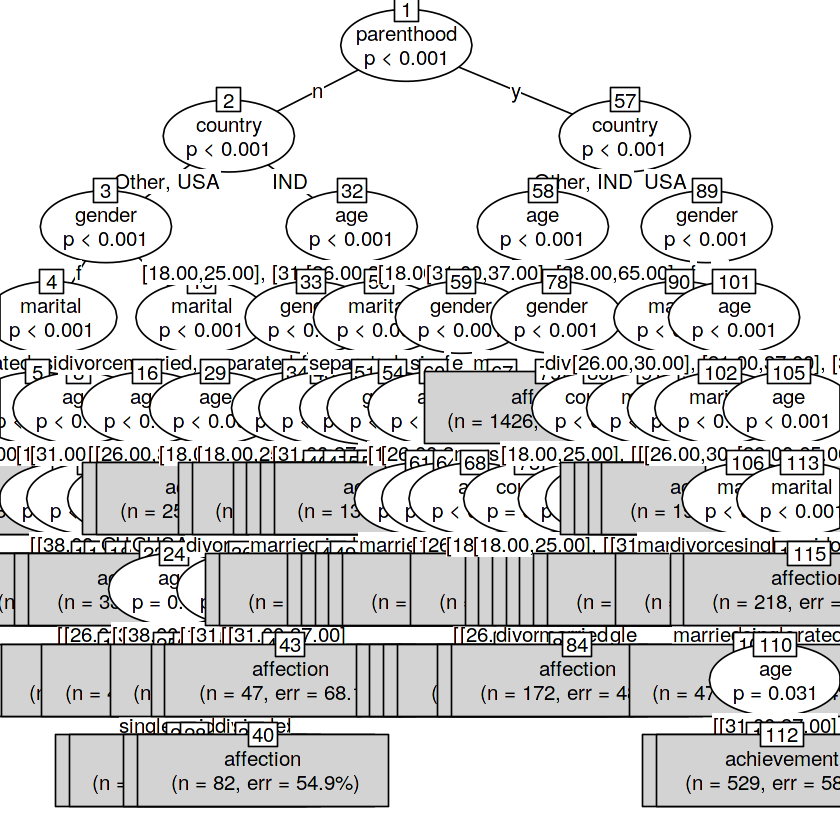

In [13]:
plot(cdt, type = "simple")

In [14]:
confusion_matrix <-table(predict(cdt,newdata=data_test), data_test$predicted_category)
confusion_matrix

                  
                   achievement affection bonding enjoy_the_moment exercise
  achievement             5058      3333    1637             1595      209
  affection               3358      5125    1032             1232       82
  bonding                    0         0       0                0        0
  enjoy_the_moment           0         0       0                0        0
  exercise                   0         0       0                0        0
  leisure                   43        73      18               24        7
  nature                     0         0       0                0        0
                  
                   leisure nature
  achievement         1078    260
  affection            670    199
  bonding                0      0
  enjoy_the_moment       0      0
  exercise               0      0
  leisure              101      0
  nature                 0      0

In [15]:
accuracy <- sum(diag(confusion_matrix))/sum(confusion_matrix)
accuracy

[1] 0.4091669

Our accuracy of the decision tree is ~41%. Guessing or picking the category at random, the accuracy would be 1/7 = aprox. 14%. So, overall, the accuracy is quite good. However, we need to take into account that our training and test data is highly unbalanced, which also has an impact on the accuracy. (see also comment in section 5.Assessment of the results and future work)

In [16]:
head(predict(cdt, type = "prob"))

achievement affection bonding    enjoy_the_moment exercise    leisure   
7   0.3218997   0.3509235 0.09709763 0.11240106       0.004749340 0.07757256
99  0.2426396   0.5640609 0.05786802 0.07776650       0.005279188 0.03979695
31  0.3850438   0.3178202 0.08035004 0.10859189       0.015910899 0.07955449
21  0.4080353   0.2138378 0.12680036 0.12349252       0.021294191 0.09151678
100 0.2752466   0.4969469 0.06317520 0.07891029       0.008454674 0.04368248
25  0.3835220   0.2151289 0.12382558 0.12768008       0.017586124 0.10840761
    nature    
7   0.03535620
99  0.01258883
31  0.01272872
21  0.01502309
100 0.03358384
25  0.02384967

In [50]:
head(predict(cdt, type = "prob"))head(predict(cdt, type = "prob"))head(predict(cdt, type = "response"))

[1] affection   achievement achievement achievement achievement affection  
7 Levels: achievement affection bonding enjoy_the_moment exercise ... nature

In [41]:
print(c(data_joined_tree[1,],predict(cdt, type = "prob")[[1]]))

$predicted_category
[1] affection
7 Levels: achievement affection bonding enjoy_the_moment exercise ... nature

$age
[1] [31.00,37.00]
Levels: [18.00,25.00] [26.00,30.00] [31.00,37.00] [38.00,65.00]

$country
[1] USA
Levels: Other IND USA

$gender
[1] m
Levels: f m

$marital
[1] single
Levels: divorced married separated single widowed

$parenthood
[1] n
Levels: n y

[[7]]
[1] 0.1900238

[[8]]
[1] 0.2731591

[[9]]
[1] 0.0736342

[[10]]
[1] 0.05463183

[[11]]
[1] 0.01900238

[[12]]
[1] 0.3895487

[[13]]
[1] 0



In [21]:
response <- predict(cdt, type = "response")
prob <- predict(cdt, type = "prob")
rls <- partykit:::.list.rules.party(cdt)
rule <- rls[as.character(predict(cdt, type = "node"))]
data_train <- cbind(data_train,response,prob,rule)

In [22]:
data_train[!duplicated(data_train$rule),][,c(1,2,3,4,5,6,7)]
nrow(data_train[!duplicated(data_train$rule),])response <- predict(cdt, type = "response")
prob <- predict(cdt, type = "prob")
rls <- partykit:::.list.rules.party(cdt)
rule <- rls[as.character(predict(cdt, type = "node"))]
data_train <- cbind(data_train,response,prob,rule)

predicted_category country gender marital   parenthood age          
82025 achievement        USA     f      married   n          [31.00,37.00]
4546  affection          USA     f      married   y          [31.00,37.00]
943   achievement        Other   m      married   n          [31.00,37.00]
61479 achievement        USA     m      single    n          [18.00,25.00]
88833 affection          USA     f      married   y          [38.00,65.00]
44084 affection          USA     m      single    n          [31.00,37.00]
42734 nature             IND     m      single    y          [18.00,25.00]
80889 achievement        IND     f      single    n          [18.00,25.00]
892   achievement        USA     f      single    n          [18.00,25.00]
71117 achievement        IND     m      married   y          [31.00,37.00]
57799 bonding            USA     f      divorced  y          [38.00,65.00]
34519 achievement        USA     f      single    n          [38.00,65.00]
55476 achievement        USA     f      married   n          [26.00,30.00]
9282  affection          IND     f      married   n          [26.00,30.00]
66173 affection          USA     m      single    n          [38.00,65.00]
43502 achievement        IND     m      single    n          [18.00,25.00]
22749 achievement        USA     f      single    n          [31.00,37.00]
37944 affection          Other   f      single    n          [18.00,25.00]
26634 affection          USA     m      married   y          [38.00,65.00]
57916 affection          USA     m      married   y          [26.00,30.00]
54032 leisure            IND     m      married   y          [26.00,30.00]
45864 affection          IND     f      single    n          [31.00,37.00]
80887 leisure            IND     m      married   y          [18.00,25.00]
63381 achievement        USA     f      separated y          [31.00,37.00]
8449  enjoy_the_moment   Other   m      single    n          [26.00,30.00]
94537 achievement        Other   m      single    n          [18.00,25.00]
20709 achievement        IND     m      single    n          [26.00,30.00]
94250 leisure            USA     m      divorced  y          [31.00,37.00]
1526  enjoy_the_moment   USA     f      divorced  y          [31.00,37.00]
61219 nature             IND     m      married   n          [31.00,37.00]
59815 achievement        IND     f      married   y          [38.00,65.00]
40735 enjoy_the_moment   IND     f      married   y          [26.00,30.00]
59458 enjoy_the_moment   USA     m      married   y          [18.00,25.00]
12639 affection          IND     m      married   y          [38.00,65.00]
9700  leisure            Other   m      married   n          [18.00,25.00]
53339 achievement        USA     m      single    y          [26.00,30.00]
23580 achievement        USA     m      single    y          [18.00,25.00]
60927 achievement        Other   m      single    y          [18.00,25.00]
59353 bonding            IND     f      married   y          [18.00,25.00]
84223 achievement        IND     m      married   n          [26.00,30.00]
4960  affection          Other   f      single    y          [18.00,25.00]
79011 achievement        USA     m      single    y          [31.00,37.00]
72174 enjoy_the_moment   USA     f      separated y          [38.00,65.00]
18216 achievement        Other   m      married   y          [31.00,37.00]
18504 enjoy_the_moment   Other   m      single    n          [31.00,37.00]
33365 enjoy_the_moment   Other   m      single    y          [38.00,65.00]
88966 leisure            IND     f      single    n          [26.00,30.00]
91024 achievement        IND     m      single    n          [31.00,37.00]
41267 enjoy_the_moment   USA     m      divorced  n          [38.00,65.00]
10016 affection          Other   m      married   y          [26.00,30.00]
79543 enjoy_the_moment   IND     f      married   n          [18.00,25.00]
34442 bonding            USA     m      widowed   y          [38.00,65.00]
36032 enjoy_the_moment   IND   

[1] 58

In [23]:
data_train <- cbind(data_train,data_joined[train,5])

In [24]:
names(data_train)[16] <- "cleaned_hm"
head(data_train)

predicted_category country gender marital parenthood age          
82025 achievement        USA     f      married n          [31.00,37.00]
4546  affection          USA     f      married y          [31.00,37.00]
943   achievement        Other   m      married n          [31.00,37.00]
61479 achievement        USA     m      single  n          [18.00,25.00]
88833 affection          USA     f      married y          [38.00,65.00]
44084 affection          USA     m      single  n          [31.00,37.00]
      response    achievement affection bonding    enjoy_the_moment exercise   
82025 affection   0.3218997   0.3509235 0.09709763 0.11240106       0.004749340
4546  affection   0.2426396   0.5640609 0.05786802 0.07776650       0.005279188
943   achievement 0.3850438   0.3178202 0.08035004 0.10859189       0.015910899
61479 achievement 0.4080353   0.2138378 0.12680036 0.12349252       0.021294191
88833 affection   0.2752466   0.4969469 0.06317520 0.07891029       0.008454674
44084 achievement 0.3835220   0.2151289 0.12382558 0.12768008       0.017586124
      leisure    nature    
82025 0.07757256 0.03535620
4546  0.03979695 0.01258883
943   0.07955449 0.01272872
61479 0.09151678 0.01502309
88833 0.04368248 0.03358384
44084 0.10840761 0.02384967
      rule                                                                                                                                                                                                                                                 
82025 parenthood %in% c("n") & country %in% c("Other", "USA") & gender %in% c("f") & marital %in% c("divorced", "married") & age %in% c("[31.00,37.00]", "[38.00,65.00]")                                                                                  
4546  parenthood %in% c("y") & country %in% c("USA") & gender %in% c("f") & marital %in% c("married", "widowed") & age %in% c("[18.00,25.00]", "[26.00,30.00]", "[31.00,37.00]")                                                                           
943   parenthood %in% c("n") & country %in% c("Other", "USA") & gender %in% c("m") & marital %in% c("married", "separated") & age %in% c("[26.00,30.00]", "[31.00,37.00]")                                                                                 
61479 parenthood %in% c("n") & country %in% c("Other", "USA") & gender %in% c("m") & marital %in% c("divorced", "single", "widowed") & age %in% c("[18.00,25.00]", "[26.00,30.00]") & country %in% c("NA", "USA")                                          
88833 parenthood %in% c("y") & country %in% c("USA") & gender %in% c("f") & marital %in% c("married", "widowed") & age %in% c("[38.00,65.00]")                                                                                                             
44084 parenthood %in% c("n") & country %in% c("Other", "USA") & gender %in% c("m") & marital %in% c("divorced", "single", "widowed") & age %in% c("[31.00,37.00]", "[38.00,65.00]") & country %in% c("NA", "USA") & age %in% c("NA", "NA", "[31.00,37.00]")
      cleaned_hm                                                                                                                                                                                                                   
82025 I found out I got an A in one of my classes                                                                                                                                                                                  
4546  My family went to a new Walmart that just opened and shopped around and found a toy for the baby.  She was happy to get the new toy and my husband was excited to buy it for her.  It made me happy to see them both happy.  
943   complete my pending job task today.                                                                                                                                                                                          
61479 When I learned that Comey was fired, I was very happy. I 

In [36]:
WhatMakesYouHappy <- function(age , country, gender, marital , parenthood){
  a <- "[18.00,25.00]"
  b <- "[26.00,30.00]"
  c <- "[31.00,37.00]"
  d <- "[38.00,65.00]"
  if(age < 26 ){ age <-  as.character(a)}
  if(age > 25 && age < 31){age <- as.character(b)}
  if(age > 30 && age < 38){age <- as.character(c)}
  if(age > 37 ){age <- as.character(d)}
  for(i in 1:length(data_train$response)){
    if(age == data_train$age[i] && country == data_train$country[i] && gender  == data_train$gender[i] && marital == data_train$marital[i] && parenthood == data_train$parenthood[i]){
      predicted_prob <- 0
      if(data_train$response[i] == "achievement"){
          predicted_prob <- data_train$achievement[i]
      }
      if(data_train$response[i] == "affection"){
          predicted_prob <- data_train$affection[i]
      }
      if(data_train$response[i] == "bonding"){
          predicted_prob <- data_train$bonding[i]
      }
      if(data_train$response[i] == "enjoy_the_moment"){
          predicted_prob <- data_train$enjoy_the_moment[i]
      }
      if(data_train$response[i] == "exercise"){
          predicted_prob <- data_train$exercise[i]
      }
      if(data_train$response[i] == "leisure"){
          predicted_prob <- data_train$leisure[i]
      }
      if(data_train$response[i] == "nature"){
          predicted_prob <- data_train$nature[i]
      }
      cat(paste("Your predicted category is :",  data_train$response[i],  "with a probability of :", round(predicted_prob*100),"%"))
      cat("\nHere you can find some examples of what made other people sharing the same category happy:\n")  
      print(data_train$cleaned_hm[data_train$predicted_category == data_train$response[i]][sample(1:length(data_train$cleaned_hm[data_train$predicted_category == data_train$response[i]]), 5, replace=F)])
      break
    }
  }
}

In [37]:
WhatMakesYouHappy(22,"Other","f","single","n")

Your predicted category is : achievement with a probability of : 47 %
Here you can find some examples of what made other people sharing the same category happy:
[1] I bought a new car today.                                                        
[2] My colleague bought me a drink for a bet i have won                              
[3] When I signed the contract to my work. Finally I am one step closer to my dreams.
[4] I built a new computer                                                           
[5] I passed a very important civil service exam with a 100.                         
96484 Levels: \n\ni signed an apartment lease for this july ...


In [50]:
WhatMakesYouHappy(29,"USA","m","married","y")

Your predicted category is : affection with a probability of : 42 %
Here you can find some examples of what made other people sharing the same category happy:
[1] I learned that my son got an A on his Spanish test.                                                        
[2] Today i got a kiss from my girlfriend who hasn't touched me in 2 years.                                    
[3] I Went to see a new movie with my daughter.                                                                
[4] Spending time with my family made me happy.                                                                
[5] I got to talk to my daughter who lives far away today, it was nice to get to see how she's doing this week.
96484 Levels: \n\ni signed an apartment lease for this july ...


In [42]:
WhatMakesYouHappy(40,"USA","m","married","y")

Your predicted category is : affection with a probability of : 43 %
Here you can find some examples of what made other people sharing the same category happy:
[1] As I was preparing dinner for the family, my son and granddaughter (not my son's daughter) decided to set the table for me. They layed everything on table including condiments, drinks, and napkins as well as serving spoons and plates. It's a small ting, but it made me happy that they just wanted to do something nice for me.
[2] I bought my mother a present.                                                                                                                                                                                                                                                                                                        
[3] I sat down with my dog and gave him a good rub down. In doing so he began to trust me more, and his anxiety and nervousness was lessened. I like making him happy because is a pa

In [49]:
WhatMakesYouHappy(27,"IND","f","married","n")

Your predicted category is : leisure with a probability of : 49 %
Here you can find some examples of what made other people sharing the same category happy:
[1] The song was used by ITV for their trailer advertising their coverage of the 2006 FIFA World Cup.\nIt was also used in a series of I'm a Celebrity... Get Me Out of Here!.[2]\nThe song was used in the background of a scene in the British science fiction series Torchwood in episode three of series one Ghost Machine.\nThe song is also used on the American TV series One Tree Hill in 3x01, "Like You Like an Arsonist".[3]\nThe song was used in the "Belgian Montage" of the program Dom Joly Happy Hour.
[2] I went  and visited a older temple in shanghai  china  .                                                                                                                                                                                                                                                                                       

In [41]:
WhatMakesYouHappy(21,"USA","m","single","n")

Your predicted category is : achievement with a probability of : 41 %
Here you can find some examples of what made other people sharing the same category happy:
[1] Positive news from work.                                                                   
[2] I got to leave work early this afternoon.                                                  
[3] We made a successful Pinterest recipe in the crock pot.                                    
[4] I completed my project file successfully and signed the deal with my client and I am happy.
[5] Completing a new record for my weightlifting                                               
96484 Levels: \n\ni signed an apartment lease for this july ...


### 5. Assessment of the results and future work

Since our decision tree was built on a data set that contains a large amount of comments for the two majority classes achievement and affection, the tree is biased towards these two majority classes. As a reminder, see the plot below that illustrates the counts of each of the happy moment categories in our data set:
<img src="images/PredictedCategories.png" alt="Drawing" style="width: 400px;"/>


The unbalanced data leads to the fact that most of the predictions yield as a label achievement or affection. Even though it is a first valid insight into what makes someone happy since achievement and affection are very contrary, it would have been even more informative to also get predictions on the other categories of happy moments.

In order to tackle this commonly known issue of unbalanced data in classification, there are several measures we might take in the future to improve our results:
- oversample the minority classes and/or undersample the majority classes during training to artificially balance the data
- increase the cost of misclassification in order to "punish" classification only towards the majority classes
- pass the prior information of the class probability to the decision tree

etc.
<br> Source: https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data